In [378]:
import pandas as pd
import os
from datetime import datetime as dt


from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score, precision_recall_curve, auc
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


import pycountry as pc

import warnings
warnings.filterwarnings('ignore')

In [379]:
# classification targets
target_conf = 'armedconf'
target_escl = 'escalation'

# regression target
target_regr = 'deaths_all_pc'

# many features are made per-country
unit_of_analyis = 'isocode'

# start and end of test set
start_month_year = dt(2018, 1, 1)
end_month_year = dt(2023, 3, 1)

# time horizons forecase for
fwds = [1,3,6]

# target groupings
clsf_targets = [target_conf, target_escl]
regr_targets = [target_regr]

all_targets = clsf_targets + regr_targets

# algorithms used
algos = ['rf', 'xgb']

## Import predictions and join with true values

In [380]:
path = os.getcwd()
parent_path = os.path.abspath(os.path.join(path, os.pardir))

### Re-create targets

Generated from all data, so need to drop training data.

In [381]:
df_og = pd.read_csv(os.path.abspath(parent_path + '/data/preprocessed_df.csv'))

df_og['month_year'] = pd.to_datetime(df_og['month_year'])

print(df_og.shape)
print(df_og.month_year.min(), df_og.month_year.max())
df_og.head()

(54915, 88)
2000-01-01 00:00:00 2023-03-01 00:00:00


isocode month_year  month  year Country Name  deaths_all_pc  armedconf  \
0     AFG 2000-01-01      1  2000  Afghanistan       0.276314       True   
1     AFG 2000-02-01      2  2000  Afghanistan       0.777290       True   
2     AFG 2000-03-01      3  2000  Afghanistan       1.620053       True   
3     AFG 2000-04-01      4  2000  Afghanistan       2.706927       True   
4     AFG 2000-05-01      5  2000  Afghanistan       0.418548       True   

   escalation     past6    past12  ...  isocode_4  isocode_5  isocode_6  \
0           0  0.276314  0.276314  ...          0          0          0   
1           1  1.053604  1.053604  ...          0          0          0   
2           0  2.673657  2.673657  ...          0          0          0   
3           0  5.380585  5.380585  ...          0          0          0   
4           0  5.799133  5.799133  ...          0          0          0   

   isocode_7  f3_target_escl  f6_target_escl  f3_target_clsf  f6_target_clsf  \
0          1             NaN             NaN             NaN             NaN   
1          1             1.0             1.0             1.0             1.0   
2          1             0.0             1.0             1.0             1.0   
3          1             0.0             1.0             1.0             1.0   
4          1             1.0             1.0             1.0             1.0   

   f3_target_regr  f6_target_regr  
0             NaN             NaN  
1        1.701424        1.600231  
2        1.581843        2.404725  
3        1.160851        3.083456  
4        1.499038        2.822271  

[5 rows x 88 columns]

In [382]:
def make_target_clsf(df: pd.DataFrame, shifter: int, target: str):

    # loop through each period and generate the shift variables (name doesn't matter, just interim columns to take max)
    for i in range(1, shifter+1):
        col_name = f'{target}{i}'
        df[col_name] = df.groupby(unit_of_analyis)[str(target)].shift(-i)

    # take the maximum for t periods forward and create the new variable & drop the shift variables
    df[f'{target}_f{shifter}'] = df[[f'{target}{i}' for i in range(1, shifter+1)]].max(axis=1, skipna=False)
    df = df.drop(columns=[f'{target}{i}' for i in range(1, shifter+1)])
    
    return(df)


def make_target_regr(df: pd.DataFrame, shifter: int, target: str): 

    # loop through each period and generate the temporary shift variables
    for i in range(1, shifter+1):
        col_name = f'{target}{i}'
        df[col_name] = df.groupby(unit_of_analyis)[str(target)].shift(-i)

    # take the mean for t periods forward and create the new variable &
    df[f'{target}_f{shifter}'] = df[[f'{target}{i}' for i in range(1, shifter+1)]].mean(axis=1, skipna=False)

    # 
    df = df.drop(columns=[f'{target}{i}' for i in range(1, shifter+1)])
    
    return(df)

In [383]:
# demonstrating the make_target functions
df_targets = df_og.copy()

# generate targets
for fwd in fwds:
    for target in clsf_targets:
        df_targets = make_target_clsf(df_targets, fwd, target)
    
    for target in regr_targets:
        df_targets = make_target_regr(df_targets, fwd, target)

# check it worked
fwd = 3
df_targets.loc[df_targets['isocode'] == 'BFA', ['isocode', 'Country Name', 'month_year',  'armedconf',  f'{target_escl}_f{fwd}', f'{target_conf}_f{fwd}','deaths_all_pc', f'{target_regr}_f{fwd}']][-8:]

isocode  Country Name month_year  armedconf  escalation_f3  \
43378     BFA  Burkina Faso 2022-08-01       True            0.0   
43379     BFA  Burkina Faso 2022-09-01       True            0.0   
43380     BFA  Burkina Faso 2022-10-01       True            0.0   
43381     BFA  Burkina Faso 2022-11-01       True            1.0   
43382     BFA  Burkina Faso 2022-12-01       True            1.0   
43383     BFA  Burkina Faso 2023-01-01      False            NaN   
43384     BFA  Burkina Faso 2023-02-01       True            NaN   
43385     BFA  Burkina Faso 2023-03-01       True            NaN   

       armedconf_f3  deaths_all_pc  deaths_all_pc_f3  
43378           1.0       1.475068          0.754125  
43379           1.0       0.868751          0.758649  
43380           1.0       0.475098          0.600283  
43381           1.0       0.918524          1.010527  
43382           1.0       0.882326          1.561038  
43383           NaN       0.000000               NaN  
43384           NaN       2.149255               NaN  
43385           NaN       2.533858               NaN

In [384]:
df_targets = df_targets.loc[df_targets['month_year'] >= start_month_year]

print(df_targets.shape)
df_targets.columns

(12411, 97)


Index(['isocode', 'month_year', 'month', 'year', 'Country Name',
       'deaths_all_pc', 'armedconf', 'escalation', 'past6', 'past12', 'past60',
       'past120', 'armedconf_since', 'deaths_stock', 'share_events_1',
       'share_events_2', 'share_events_3', 'share_events_4', 'share_events_5',
       'share_events_6', 'share_events_7', 'share_events_8', 'share_events_9',
       'share_events_10', 'share_events_11', 'share_events_12',
       'share_events_13', 'share_events_14', 'share_events_15',
       'share_events_16', 'share_events_17', 'share_events_18',
       'share_events_19', 'share_events_20', 'share_events_gov',
       'share_events_opp', 'norm_total_events', 'event_share_1_stock',
       'event_share_2_stock', 'event_share_3_stock', 'event_share_4_stock',
       'event_share_5_stock', 'event_share_6_stock', 'event_share_7_stock',
       'event_share_8_stock', 'event_share_9_stock', 'event_share_10_stock',
       'event_share_11_stock', 'event_share_12_stock', 'event_share_1

### Import predictions

All are joined into a single data frame.

In [385]:
df_preds = pd.read_csv(os.path.abspath(path + f'/tree_based_pred/Final/predictions_rf_f1_escalation.csv'))
df_preds = df_preds[['isocode', 'month_year']]
df_preds['month_year'] = pd.to_datetime(df_preds['month_year'])

print(df_preds.shape, df_targets.shape)
print(df_preds.month_year.min(), df_preds.month_year.max())
print(df_targets.month_year.min(), df_targets.month_year.max())

df_preds.head()

(12411, 2) (12411, 97)
2018-01-01 00:00:00 2023-03-01 00:00:00
2018-01-01 00:00:00 2023-03-01 00:00:00


isocode month_year
0     AFG 2018-01-01
1     AGO 2018-01-01
2     ALB 2018-01-01
3     ARE 2018-01-01
4     ARG 2018-01-01

In [386]:
for algo in algos:
    for fwd in fwds:
        for target in all_targets: # all_targets

            df_temp = pd.read_csv(os.path.abspath(path + f'/tree_based_pred/Final/predictions_{algo}_f{fwd}_{target}.csv'))
            df_temp.drop(columns=['Unnamed: 0'], inplace=True)
            
            df_temp['month_year'] = pd.to_datetime(df_temp['month_year'], format='%Y-%m-%d')
            df_temp.sort_values(by=['month_year', 'isocode'], inplace=True)
            
            print(df_temp.shape, df_temp.month_year.min(), df_temp.month_year.max())
            
            #print(df_temp.columns )
            #df_preds = pd.concat([df_preds, df_temp], axis=1)

            df_preds = df_preds.merge(df_temp, how='left', on=['isocode', 'month_year'])

(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00
(12411, 5) 2018-01-01 00:00:00 2023-03-01 00:00:00


In [387]:
df_preds = df_preds.loc[:,~df_preds.T.duplicated(keep='first')]

print(df_preds.shape)
#df_preds.columns
df_preds.head(2)

(12411, 56)


isocode month_year  pred_armedconf_rf_f1_all  pred_armedconf_rf_f1_hs  \
0     AFG 2018-01-01                  0.988908                 0.991190   
1     AGO 2018-01-01                  0.210516                 0.235263   

   pred_armedconf_rf_f1_tx  pred_escalation_rf_f1_all  \
0                 0.958227                   0.558911   
1                 0.351255                   0.039969   

   pred_escalation_rf_f1_hs  pred_escalation_rf_f1_tx  \
0                  0.209395                  0.878587   
1                  0.138536                  0.080404   

   pred_deaths_all_pc_rf_f1_all  pred_deaths_all_pc_rf_f1_hs  ...  \
0                     11.127582                    11.223889  ...   
1                      0.009906                     0.008070  ...   

   pred_deaths_all_pc_xgb_f3_tx  pred_armedconf_xgb_f6_all  \
0                      3.572988                   1.000000   
1                      0.153685                   0.017353   

   pred_armedconf_xgb_f6_hs  pred_armedconf_xgb_f6_tx  \
0                  0.999882                  1.000000   
1                  0.001365                  0.025607   

   pred_escalation_xgb_f6_all  pred_escalation_xgb_f6_hs  \
0                    0.992035                   0.995094   
1                    0.000640                   0.009946   

   pred_escalation_xgb_f6_tx  pred_deaths_all_pc_xgb_f6_all  \
0                   0.999671                       2.151273   
1                   0.004745                       0.192119   

   pred_deaths_all_pc_xgb_f6_hs  pred_deaths_all_pc_xgb_f6_tx  
0                      2.929380                      2.874567  
1                      0.187882                      0.188585  

[2 rows x 56 columns]

In [388]:
print('armed conflicts:', df_og[target_conf].sum())
print('perc of observ.:', df_og[target_conf].sum()/len(df_og)*100)

## with old preprocessing
# armed conflicts: 7144
# perc of observ.: 8.94397496087637

armed conflicts: 4594
perc of observ.: 8.36565601383957


### Join targets & predictions

Single data frame from which to generate metrics.

In [389]:
df_targ = df_targets.copy()
df_pred = df_preds.copy()

In [390]:
# ensure same order or sorting
df_targ.sort_values(by=['month_year', 'isocode'], inplace=True)
df_targ.reset_index(drop=True, inplace=True)
df_targ['month_year'] = pd.to_datetime(df_targ['month_year'], format='%Y-%m-%d')

# important to reset indices so that concatenation does not genrate additional rows
df_targ.reset_index(inplace=True) 
df_pred.reset_index(inplace=True)

# check same length
print(df_targ.shape, df_pred.shape)

# concatenate the two dataframes
#df_joined = pd.concat([df_targ, df_pred], axis=1)
df_joined = df_targ.merge(df_pred, how='left', on=['isocode', 'month_year'])

df = df_joined.copy()

df = df.loc[:,~df.T.duplicated(keep='first')]
df.drop(columns=['index_x'], inplace=True)

print(df.shape)
df.head(2)

(12411, 98) (12411, 57)
(12411, 151)


isocode month_year  month  year Country Name  deaths_all_pc  armedconf  \
0     AFG 2018-01-01      1  2018  Afghanistan       4.838255       True   
1     AGO 2018-01-01      1  2018       Angola       0.000000      False   

   escalation      past6     past12  ...  pred_deaths_all_pc_xgb_f3_tx  \
0           1  30.689119  55.771793  ...                      3.572988   
1           0   0.012864   0.085440  ...                      0.153685   

   pred_armedconf_xgb_f6_all  pred_armedconf_xgb_f6_hs  \
0                   1.000000                  0.999882   
1                   0.017353                  0.001365   

   pred_armedconf_xgb_f6_tx  pred_escalation_xgb_f6_all  \
0                  1.000000                    0.992035   
1                  0.025607                    0.000640   

   pred_escalation_xgb_f6_hs  pred_escalation_xgb_f6_tx  \
0                   0.995094                   0.999671   
1                   0.009946                   0.004745   

   pred_deaths_all_pc_xgb_f6_all  pred_deaths_all_pc_xgb_f6_hs  \
0                       2.151273                      2.929380   
1                       0.192119                      0.187882   

   pred_deaths_all_pc_xgb_f6_tx  
0                      2.874567  
1                      0.188585  

[2 rows x 151 columns]

In [391]:
# export for the map

historical_vars = ['deaths_stock', 'past6', 'past12', 'past60', 'past120',
                   'share_state_deaths', 'share_nonstate_deaths', 'share_onesided_deaths', 'share_civilian_deaths',
                   'refugees_in', 'refugees_out', 'neighbor_conflict']
                    # don't drop as needed for naive model: 'deaths_all_pc', 'armedconf', 'escalation'
                    # don't drop as needed for hard cases: 'armedconf_since'

event_shares = ['share_events_{}'.format(i) for i in range(1, 21)] 
event_share_stock = ['event_share_{}_stock'.format(i) for i in range(1, 21)]
event_share_actor = ['share_events_gov', 'share_events_opp']
event_total = ['norm_total_events']
gdelt_admin1 = ['num_regions', 'Adm1_Max', 'Adm1_Mean', 'Adm1_Median']
clusters = ['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3']

text_gdelt_vars = event_shares + event_share_stock + event_share_actor + event_total + gdelt_admin1 + clusters
other_vars = ['month_sin', 'month_cos', 'isocode_0','isocode_1','isocode_2','isocode_3','isocode_4','isocode_5','isocode_6','isocode_7'] 
lstm_vars = ['f3_target_escl','f6_target_escl','f3_target_clsf','f6_target_clsf','f3_target_regr','f6_target_regr']

df = df.drop(columns = historical_vars + other_vars + lstm_vars) # not to drop so that can show gdelt vars alongside others
#df.to_csv(os.path.abspath(path + f'/tree_based_pred/Final/df_tree_based_joined.csv'), index=False)

In [392]:
#df_hard_cases = df.groupby('isocode').filter(lambda x: x['armedconf_since'].max() >= 120)
#df_hard_cases_conf = df_hard_cases.loc[df_hard_cases['armedconf'] ==1]

df_peacef_cntr = df.loc[df['armedconf_since'] >= 120]
list_peacef_cntr = df_peacef_cntr.isocode.unique()

df_hard_cases = df.loc[df['isocode'].isin(list_peacef_cntr)]
df_hard_cases_conf = df_hard_cases.loc[df_hard_cases['armedconf'] ==1]
list_hard_cases_conf = df_hard_cases_conf.isocode.unique()

print(list_hard_cases_conf, df_hard_cases_conf['Country Name'].unique(), len(df_hard_cases_conf.isocode.unique()))
df_hard_cases_conf

['SWZ' 'TZA' 'ECU' 'KGZ' 'ZAF' 'BEN' 'GNB' 'SLV' 'TGO' 'STP' 'MRT'] ['Eswatini' 'Tanzania' 'Ecuador' 'Kyrgyz Republic' 'South Africa' 'Benin'
 'Guinea-Bissau' 'El Salvador' 'Togo' 'Sao Tome and Principe' 'Mauritania'] 11


isocode month_year  month  year           Country Name  deaths_all_pc  \
3516      SWZ 2019-06-01      6  2019               Eswatini       0.085163   
6274      SWZ 2020-08-01      8  2020               Eswatini       0.084215   
6682      TZA 2020-10-01     10  2020               Tanzania       0.058621   
7339      ECU 2021-02-01      2  2021                Ecuador       0.443877   
7777      KGZ 2021-04-01      4  2021        Kyrgyz Republic       0.582803   
8244      SWZ 2021-06-01      6  2021               Eswatini       3.774310   
8324      ECU 2021-07-01      7  2021                Ecuador       0.123611   
8468      ZAF 2021-07-01      7  2021           South Africa       0.072400   
8718      ECU 2021-09-01      9  2021                Ecuador       0.663006   
9032      SWZ 2021-10-01     10  2021               Eswatini       0.167747   
9112      ECU 2021-11-01     11  2021                Ecuador       0.382071   
9665      BEN 2022-02-01      2  2022                  Benin       0.069247   
9721      GNB 2022-02-01      2  2022          Guinea-Bissau       0.533794   
10008     SLV 2022-03-01      3  2022            El Salvador       0.981919   
10097     ECU 2022-04-01      4  2022                Ecuador       0.112374   
10294     ECU 2022-05-01      5  2022                Ecuador       0.269697   
10415     TGO 2022-05-01      5  2022                   Togo       0.092541   
10688     ECU 2022-07-01      7  2022                Ecuador       0.073043   
10809     TGO 2022-07-01      7  2022                   Togo       0.416434   
11126     KGZ 2022-09-01      9  2022        Kyrgyz Republic       0.941451   
11241     BEN 2022-10-01     10  2022                  Benin       0.069247   
11279     ECU 2022-10-01     10  2022                Ecuador       0.123611   
11476     ECU 2022-11-01     11  2022                Ecuador       0.095518   
11588     STP 2022-11-01     11  2022  Sao Tome and Principe       1.792862   
11597     TGO 2022-11-01     11  2022                   Togo       0.219785   
12188     TGO 2023-02-01      2  2023                   Togo       0.508975   
12337     MRT 2023-03-01      3  2023             Mauritania       0.086674   

       armedconf  escalation  armedconf_since  share_events_1  ...  \
3516        True           1                0       19.273743  ...   
6274        True           1                0       20.840630  ...   
6682        True           1                0       17.857143  ...   
7339        True           1                0       15.683521  ...   
7777        True           1                0       12.186837  ...   
8244        True           1                0       14.230769  ...   
8324        True           1                0       12.358704  ...   
8468        True           1                0       14.730120  ...   
8718        True           1                0       16.264722  ...   
9032        True           1                0       13.762486  ...   
9112        True           1                0       13.537811  ...   
9665        True           1                0       10.671525  ...   
9721        True           1                0       17.364532  ...   
10008       True           1                0       14.553473  ...   
10097       True           1                0       13.640099  ...   
10294       True           1                0       13.122924  ...   
10415       True           1                0       16.603774  ...   
10688       True           1                0       13.293651  ...   
10809       True           1                0       14.748784  ...   
11126       True           1                0        9.400998  ...   
11241       True           1                0       11.157895  ...   
11279       True           1                0        9.883199  ...   
11476       True           0                0       13.459716  ...   
11588       True           1                0       15.662651  ...   
11597       True           1               

## Metrics helper functions

In [393]:
# Allows us to obtain the predictions for a given target and original shifted data

def get_tar_pred(df: pd.DataFrame() , fwd: int, model: str, start_time: dt, target: str, algo: str):
    
    target_col = f'{target}_f{fwd}'
    pred_col = f'pred_{target}_{algo}_f{fwd}_{model}'

    df = df[[unit_of_analyis, 'month_year', target_col, pred_col]] 


    #df['month_year'] = pd.to_datetime(df['date_str'])
    #df = df[df.month_year >= start_time]
        
    df = df.dropna()

    y_preds = df[pred_col]
    y_trues = df[target_col]


    return y_trues, y_preds



In [394]:
# different levels forward will have different shapes due to NaN values being dropped
exmpl_df = pd.DataFrame(get_tar_pred(df, 6, 'tx', start_month_year, target_conf, 'rf'))

print(exmpl_df.shape)
#exmpl_df.head(2)

(2, 11229)


In [395]:
def get_roc_pr(df_og: pd.DataFrame, fwd: int, target: str, models: list, staryearid, algo = str): #binary=True, plot=True
    """Function to return the roc and pr values for a given target, level and forward period"""
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    
    for model in models:

        y_true, y_pred = get_tar_pred(df=df_og, fwd=fwd, model=model,start_time=staryearid, target=target,
                                        algo = algo)
    
        roc = roc_auc_score(y_true, y_pred)
        pr = average_precision_score(y_true, y_pred)
    
        # Compute the FPR & TPR and calculate the AUC
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
        y_pred_binary = (y_pred > 0.5).astype(int)
        # Compute precision, recall, and thresholds for PR curve
        precision, recall, thresholds_pr = precision_recall_curve(y_true, y_pred)
    
        print('Model:', model)
        print('ROC:', round(roc, 3), 'Precision:', round(pr, 3))
        
        # Generate classification report
        class_report = classification_report(y_true, y_pred_binary)
        print('\nClassification Report:\n', class_report)
    
        # Plot ROC curve
        axs[0].plot(fpr, tpr, lw=2, label=f'ROC curve {model} (area = {roc_auc:.2f})')
    
        # Plot precision-recall curve
        axs[1].plot(recall, precision, lw=2, label=f'Precision-Recall curve {model} (prec: {pr:.2f})')
    
        axs[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axs[0].set_xlim([0.0, 1.0])
        axs[0].set_ylim([0.0, 1.05])
        axs[0].set_xlabel('False Positive Rate (FP/(FP+TN))')
        axs[0].set_ylabel('True Positive Rate/Recall (TP/(TP+FN))')
        axs[0].set_title(f'ROCs for {target} {fwd} month(s) ahead')
        axs[0].legend(loc="lower right")
        
        axs[1].set_xlabel('Recall (TP/(TP+FN))')
        axs[1].set_ylabel('Precision (TP/(TP+FP))')
        axs[1].set_title('Precision-Recall Curve')
        axs[1].legend(loc="lower left")
        
        plt.tight_layout()
    fig.savefig(path + f'/tree_based_pred/Final/curves/ROC_{target}_{algo}_f{fwd}.png') #path + ''  + 

    #/Users/margheritaphilipp/Documents/GitHub/thesis/models/tree_based_pred/Final/curves
    plt.show()

    


## ROC and precision re-call curves (for classification)

In [396]:
os.getcwd() 

'/Users/margheritaphilipp/Documents/GitHub/thesis/models'

TARGET: armedconf f1
Model: all
ROC: 0.983 Precision: 0.896

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.93      0.96     10962
         1.0       0.59      0.95      0.73      1252

    accuracy                           0.93     12214
   macro avg       0.79      0.94      0.85     12214
weighted avg       0.95      0.93      0.94     12214

Model: tx
ROC: 0.956 Precision: 0.784

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.91      0.95     10962
         1.0       0.53      0.87      0.65      1252

    accuracy                           0.91     12214
   macro avg       0.75      0.89      0.80     12214
weighted avg       0.94      0.91      0.92     12214

Model: hs
ROC: 0.983 Precision: 0.901

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.92      0.96     10962
         1.0       0.59   

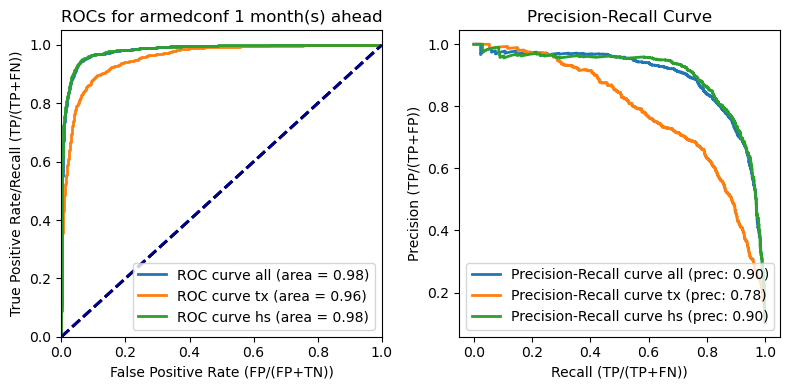

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
TARGET: armedconf f3
Model: all
ROC: 0.975 Precision: 0.911

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.93      0.96     10225
         1.0       0.67      0.92      0.77      1595

    accuracy                           0.93     11820
   macro avg       0.83      0.92      0.86     11820
weighted avg       0.94      0.93      0.93     11820

Model: tx
ROC: 0.943 Precision: 0.788

Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.91      0.94     10225
         1.0       0.58      0.83      0.68      1595

    accuracy                           0.90     11820
   macro avg       0.78      0.87      0.81     11820
weighted avg       0.92      0.90      0.90     11820

Model: hs
ROC: 0.977 Precision: 0.921

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99   

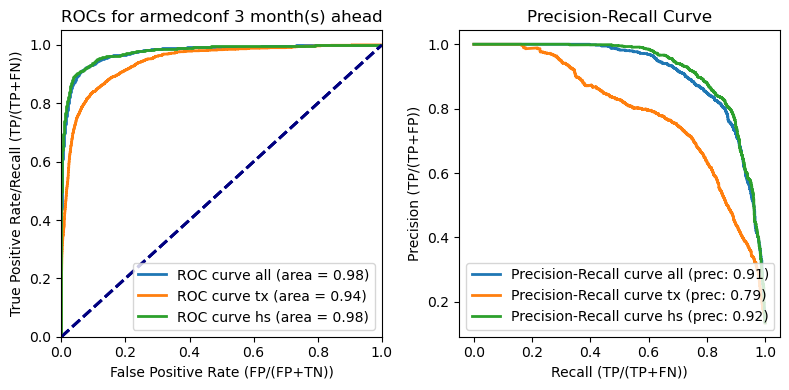

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
TARGET: armedconf f6
Model: all
ROC: 0.967 Precision: 0.901

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.92      0.95      9429
         1.0       0.69      0.89      0.77      1800

    accuracy                           0.92     11229
   macro avg       0.83      0.90      0.86     11229
weighted avg       0.93      0.92      0.92     11229

Model: tx
ROC: 0.932 Precision: 0.783

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.89      0.92      9429
         1.0       0.59      0.82      0.68      1800

    accuracy                           0.88     11229
   macro avg       0.77      0.85      0.80     11229
weighted avg       0.90      0.88      0.89     11229

Model: hs
ROC: 0.97 Precision: 0.912

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98    

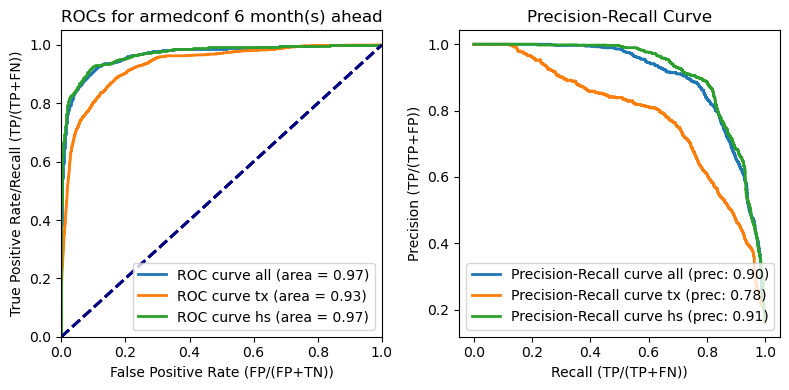

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
TARGET: armedconf f1
Model: all
ROC: 0.983 Precision: 0.904

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.99      0.98     10962
         1.0       0.90      0.78      0.83      1252

    accuracy                           0.97     12214
   macro avg       0.94      0.88      0.91     12214
weighted avg       0.97      0.97      0.97     12214

Model: tx
ROC: 0.972 Precision: 0.854

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.99      0.97     10962
         1.0       0.90      0.62      0.73      1252

    accuracy                           0.95     12214
   macro avg       0.93      0.80      0.85     12214
weighted avg       0.95      0.95      0.95     12214

Model: hs
ROC: 0.983 Precision: 0.905

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98   

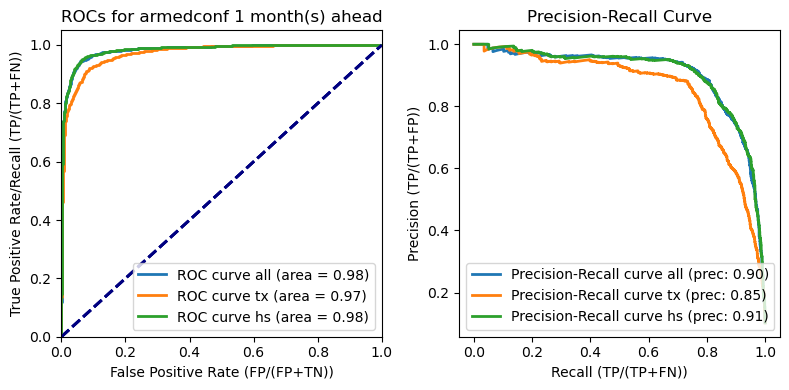

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
TARGET: armedconf f3
Model: all
ROC: 0.974 Precision: 0.914

Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.98      0.97     10225
         1.0       0.86      0.79      0.83      1595

    accuracy                           0.96     11820
   macro avg       0.92      0.89      0.90     11820
weighted avg       0.95      0.96      0.95     11820

Model: tx
ROC: 0.951 Precision: 0.832

Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.98      0.96     10225
         1.0       0.85      0.65      0.74      1595

    accuracy                           0.94     11820
   macro avg       0.90      0.82      0.85     11820
weighted avg       0.93      0.94      0.93     11820

Model: hs
ROC: 0.976 Precision: 0.922

Classification Report:
               precision    recall  f1-score   support

         0.0       0.97   

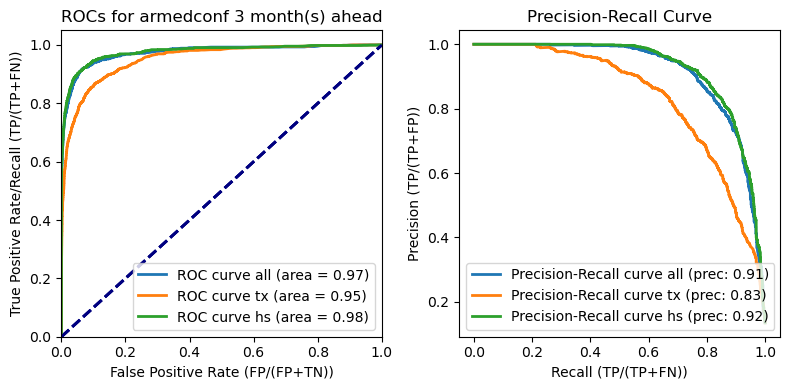

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
TARGET: armedconf f6
Model: all
ROC: 0.956 Precision: 0.888

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      9429
         1.0       0.88      0.76      0.82      1800

    accuracy                           0.95     11229
   macro avg       0.92      0.87      0.89     11229
weighted avg       0.94      0.95      0.94     11229

Model: tx
ROC: 0.951 Precision: 0.859

Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.98      0.96      9429
         1.0       0.87      0.68      0.76      1800

    accuracy                           0.93     11229
   macro avg       0.90      0.83      0.86     11229
weighted avg       0.93      0.93      0.93     11229

Model: hs
ROC: 0.962 Precision: 0.891

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96   

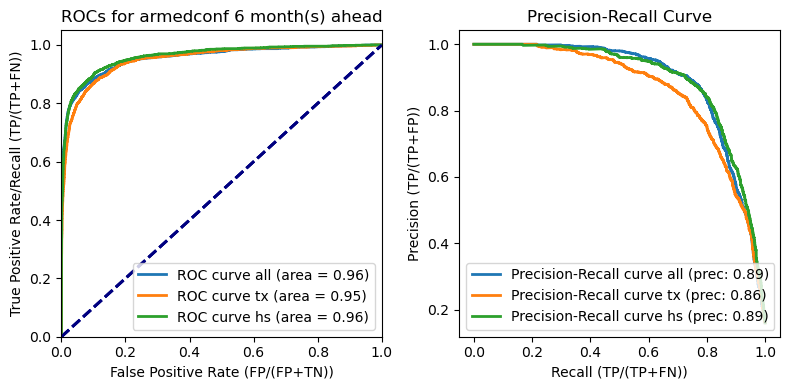

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
TARGET: escalation f1
Model: all
ROC: 0.924 Precision: 0.316

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.91      0.95     11739
         1.0       0.24      0.72      0.36       475

    accuracy                           0.90     12214
   macro avg       0.61      0.82      0.65     12214
weighted avg       0.96      0.90      0.92     12214

Model: tx
ROC: 0.898 Precision: 0.217

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.90      0.94     11739
         1.0       0.21      0.64      0.32       475

    accuracy                           0.89     12214
   macro avg       0.60      0.77      0.63     12214
weighted avg       0.95      0.89      0.92     12214

Model: hs
ROC: 0.932 Precision: 0.342

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99  

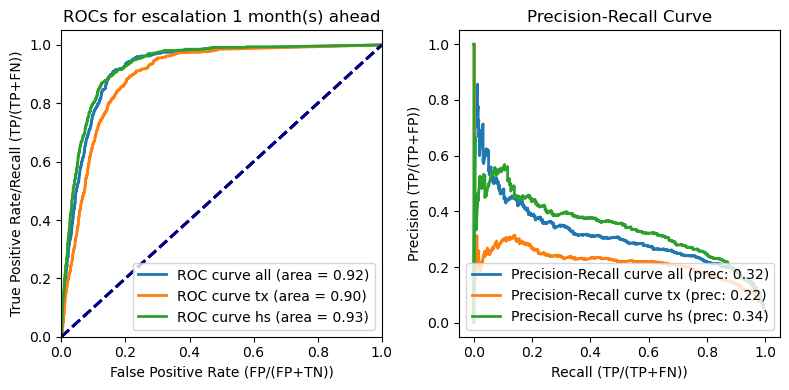

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
TARGET: escalation f3
Model: all
ROC: 0.944 Precision: 0.6

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.92      0.95     10642
         1.0       0.52      0.84      0.64      1178

    accuracy                           0.91     11820
   macro avg       0.75      0.88      0.80     11820
weighted avg       0.94      0.91      0.92     11820

Model: tx
ROC: 0.924 Precision: 0.532

Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.91      0.94     10642
         1.0       0.48      0.76      0.59      1178

    accuracy                           0.89     11820
   macro avg       0.73      0.84      0.77     11820
weighted avg       0.92      0.89      0.90     11820

Model: hs
ROC: 0.948 Precision: 0.631

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98    

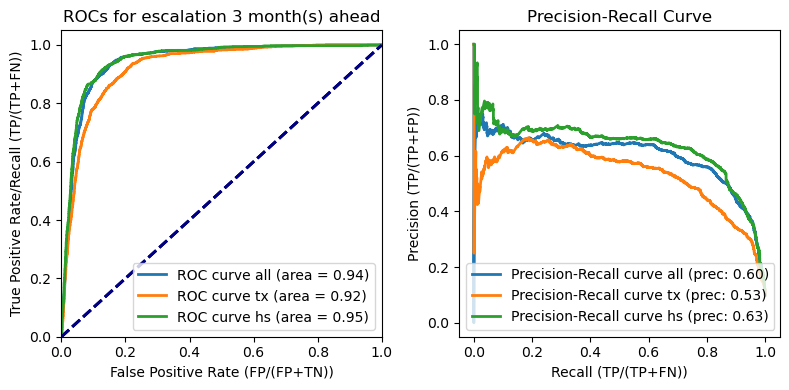

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
TARGET: escalation f6
Model: all
ROC: 0.954 Precision: 0.781

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.90      0.94      9592
         1.0       0.61      0.88      0.72      1637

    accuracy                           0.90     11229
   macro avg       0.79      0.89      0.83     11229
weighted avg       0.92      0.90      0.91     11229

Model: tx
ROC: 0.921 Precision: 0.695

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.87      0.91      9592
         1.0       0.51      0.81      0.63      1637

    accuracy                           0.86     11229
   macro avg       0.74      0.84      0.77     11229
weighted avg       0.90      0.86      0.87     11229

Model: hs
ROC: 0.958 Precision: 0.806

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98  

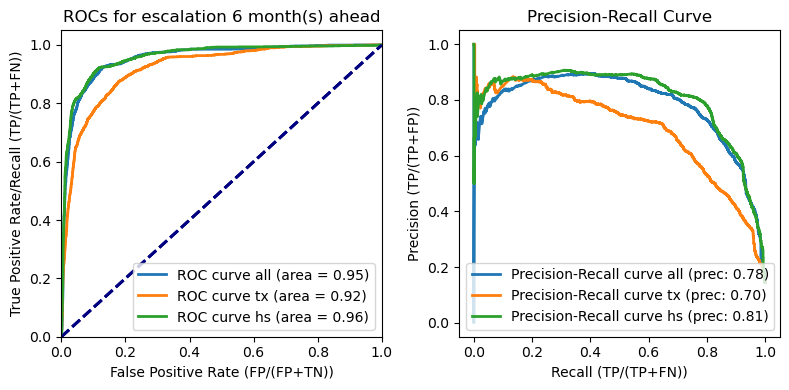

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
TARGET: escalation f1
Model: all
ROC: 0.92 Precision: 0.347

Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     11739
         1.0       0.46      0.20      0.28       475

    accuracy                           0.96     12214
   macro avg       0.72      0.59      0.63     12214
weighted avg       0.95      0.96      0.95     12214

Model: tx
ROC: 0.889 Precision: 0.216

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.99      0.98     11739
         1.0       0.32      0.06      0.10       475

    accuracy                           0.96     12214
   macro avg       0.64      0.53      0.54     12214
weighted avg       0.94      0.96      0.94     12214

Model: hs
ROC: 0.921 Precision: 0.348

Classification Report:
               precision    recall  f1-score   support

         0.0       0.97   

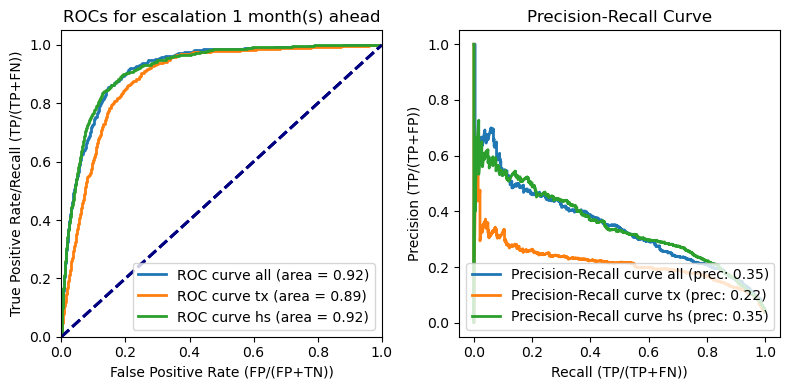

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
TARGET: escalation f3
Model: all
ROC: 0.941 Precision: 0.624

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.96      0.96     10642
         1.0       0.64      0.68      0.66      1178

    accuracy                           0.93     11820
   macro avg       0.80      0.82      0.81     11820
weighted avg       0.93      0.93      0.93     11820

Model: tx
ROC: 0.919 Precision: 0.537

Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.97      0.95     10642
         1.0       0.62      0.40      0.49      1178

    accuracy                           0.92     11820
   macro avg       0.78      0.69      0.72     11820
weighted avg       0.91      0.92      0.91     11820

Model: hs
ROC: 0.946 Precision: 0.654

Classification Report:
               precision    recall  f1-score   support

         0.0       0.97  

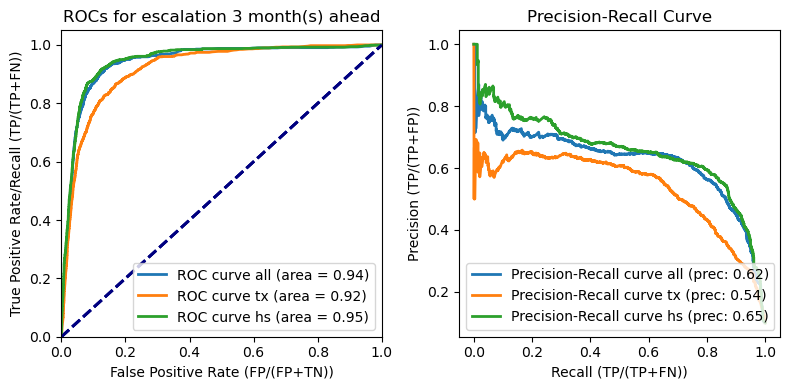

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
TARGET: escalation f6
Model: all
ROC: 0.947 Precision: 0.779

Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.97      0.96      9592
         1.0       0.80      0.72      0.76      1637

    accuracy                           0.93     11229
   macro avg       0.88      0.84      0.86     11229
weighted avg       0.93      0.93      0.93     11229

Model: tx
ROC: 0.939 Precision: 0.748

Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.97      0.95      9592
         1.0       0.78      0.62      0.69      1637

    accuracy                           0.92     11229
   macro avg       0.86      0.79      0.82     11229
weighted avg       0.91      0.92      0.91     11229

Model: hs
ROC: 0.947 Precision: 0.787

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96  

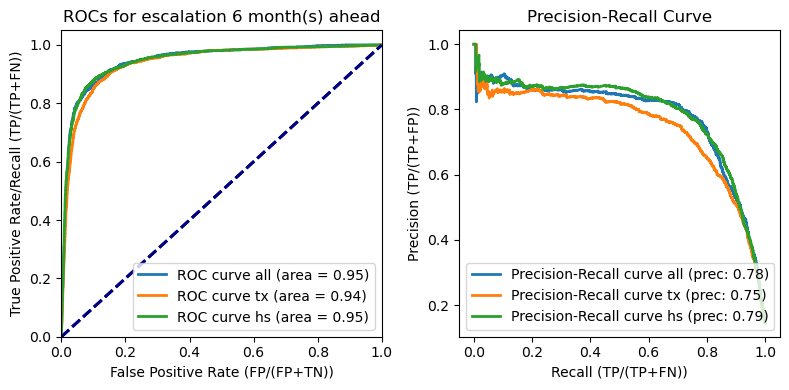

- - - - -- - - - - - - - - - - - - - - - - - - - - - 


In [397]:
for algo in algos:
    for target in ['armedconf']:
        for sft in [1,3,6]: #,2]:
            print('TARGET:', target, f'f{sft}') #, model)
            get_roc_pr(df, sft, target, ['all', 'tx', 'hs'], start_month_year, algo = algo)
            print('- - - - -- - - - - - - - - - - - - - - - - - - - - - ')

for algo in algos:
    for target in ['escalation']:
        for sft in [1,3,6]: #,2]:
            print('TARGET:', target, f'f{sft}') #, model)
            get_roc_pr(df, sft, target, ['all', 'tx', 'hs'], start_month_year, algo = algo)
            print('- - - - -- - - - - - - - - - - - - - - - - - - - - - ')

## Separation Plots (for classification)

Could be adapted for months since.

In [398]:
def separation_plot(pdata, fname, alpha=1):
    '''
    Display observed events against predicted probabilities for binary classification problems
    Arguments
    ---------
        y : vector of observed class labels
        yhat : vector of predicted probabilities
        fname: file path to directory to save plot 
        alpha: float from 0 to 1, transparency of indicators of observed events
    '''

    pdata.columns = ['y', 'yhat']
    pdata = pdata.sort_values('yhat')
    pdata = pdata.reset_index(drop=True)

    events = pdata[pdata['y'] == 1]
    evals = events.index.values

    fig = plt.figure(figsize=(20, 5))
    plt.ylabel('Predicted risk')
    ax = plt.gca()
    ax.set_xlim([1, (evals[-1] + 1)])
    ax.set_ylim([0, 1])
    
    rr = 0
    for i in evals:
        if rr == 0:
            ax.axvline(x=i, linewidth=0.2, linestyle='-', color='k', alpha=alpha, label = 'Increases', zorder=2)
            rr = 1
        else:
            ax.axvline(x=i, linewidth=0.2, linestyle='-', color='k', alpha=alpha, zorder=1)
    
    ax.plot(pdata['yhat'], linestyle='--', color='red', lw = 4, label = 'Predicted increase', zorder=3)
    ax.set_xlabel('Rank of prediction')
    ax.legend(loc="upper left")
    #plt.savefig(fname)
    plt.show()
    #fig.savefig(f'sep_plot_{target}_{algo}_f{forward}.png')
    plt.close() 

In [399]:
#monthsince as the key sufficient statistic - make sure you understand

def produce_stats(df, true_vals, pred_vals): #monthsince

    #drop any rows for which there are no predictions
    restricted=df.dropna(subset=[true_vals,f'{pred_vals}_all', f'{pred_vals}_hs', f'{pred_vals}_tx'])
    
    # IGNORED
    #only keep observations where there has been at least (0) months of peace
    #restricted=restricted[restricted["anyviolence_dp"]>=monthsince] #anyviolence_dp counts months of peace duration
    
    y_true=restricted[true_vals]

    # full model
    #y_scores=restricted[f'{pred_vals}_all']
    #print("observations:", len(y_scores))
    #print("full model AUC:", roc_auc_score(y_true.astype('int'), restricted[f'{pred_vals}_all']), "and av.precision:", average_precision_score(y_true.astype('int'), y_scores))

    # history model
    #y_scores=restricted[f'{pred_vals}_hs']
    #print("history model AUC:", roc_auc_score(y_true.astype('int'), restricted[f'{pred_vals}_hs']), "and av.precision:", average_precision_score(y_true.astype('int'), y_scores))

    # text model
    #y_scores=restricted[f'{pred_vals}_tx']
    #print("text model AUC:", roc_auc_score(y_true.astype('int'), restricted[f'{pred_vals}_tx']), "and av.precision:", average_precision_score(y_true.astype('int'), y_scores))

    # Print separation plots
    print("")

    print('Full model separation plot:')
    sep_data=restricted[[true_vals,f'{pred_vals}_all']]
    #name=Path(spitout + "{}_separation_plot.pdf".format(model_fitted))
    separation_plot(sep_data, 'name')

    print('History model separation plot:')
    sep_data=restricted[[true_vals,f'{pred_vals}_hs']]
    #name=Path(spitout + "{}_separation_plot.pdf".format(model_fitted))
    separation_plot(sep_data, 'name')

    print('Text model separation plot:')
    sep_data=restricted[[true_vals,f'{pred_vals}_tx']]
    #name=Path(spitout + "{}_separation_plot.pdf".format(model_fitted))
    separation_plot(sep_data, 'name')
    

-----------------------------------------------------------------------------------------
STATISTICS FOR TAGRET armedconf, predicting 1 month(s) ahead

Full model separation plot:


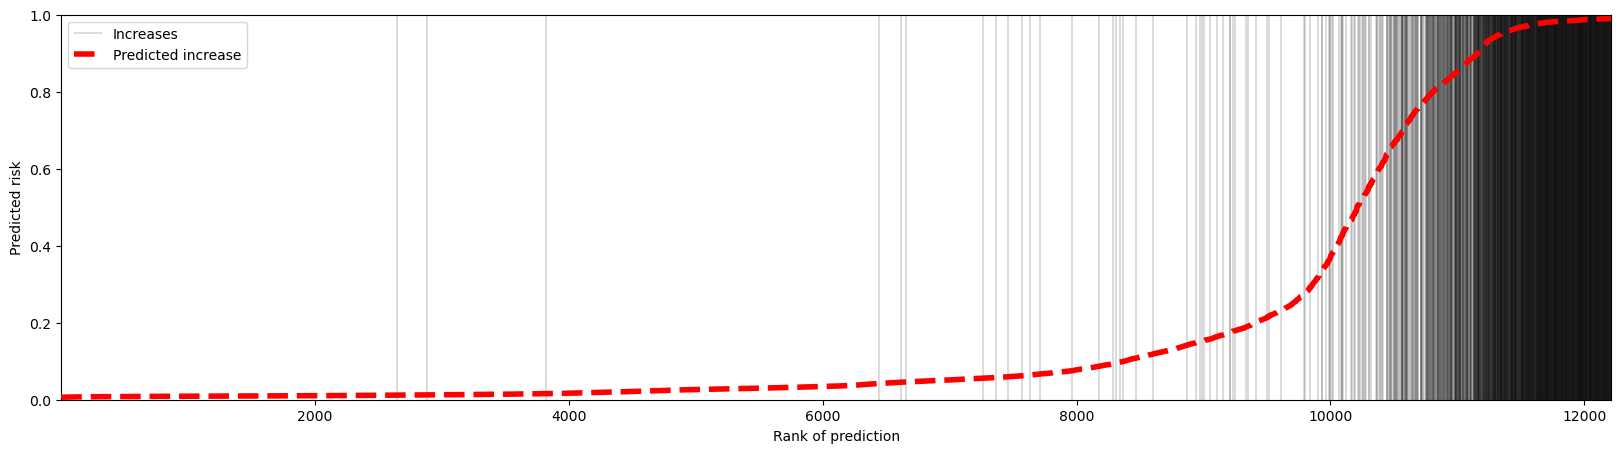

History model separation plot:


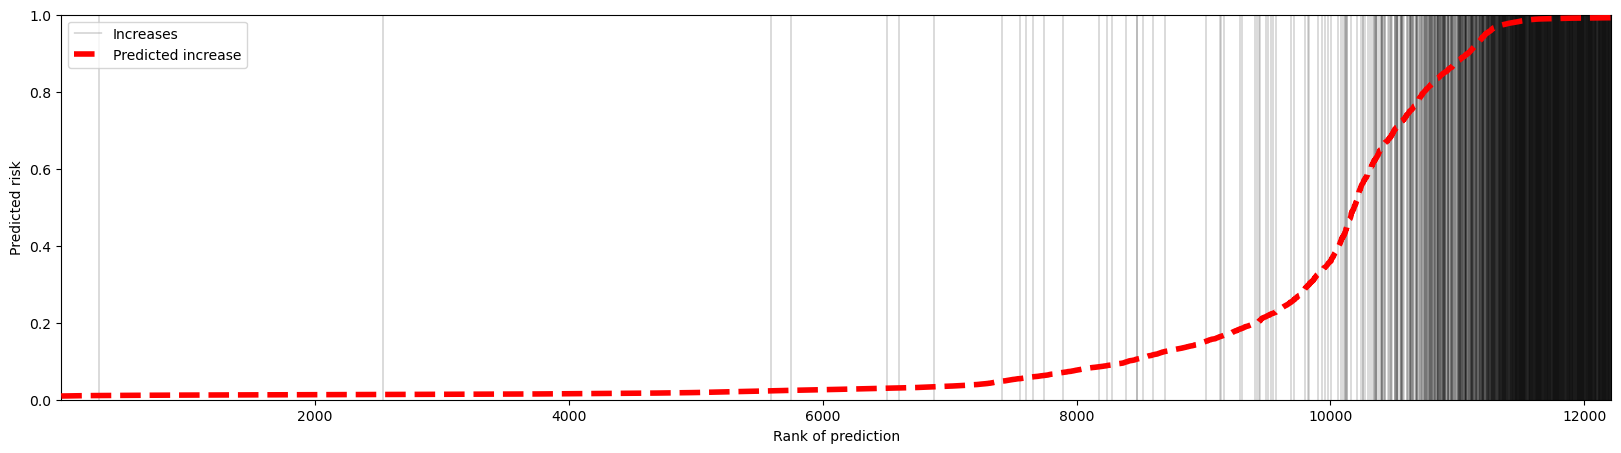

Text model separation plot:


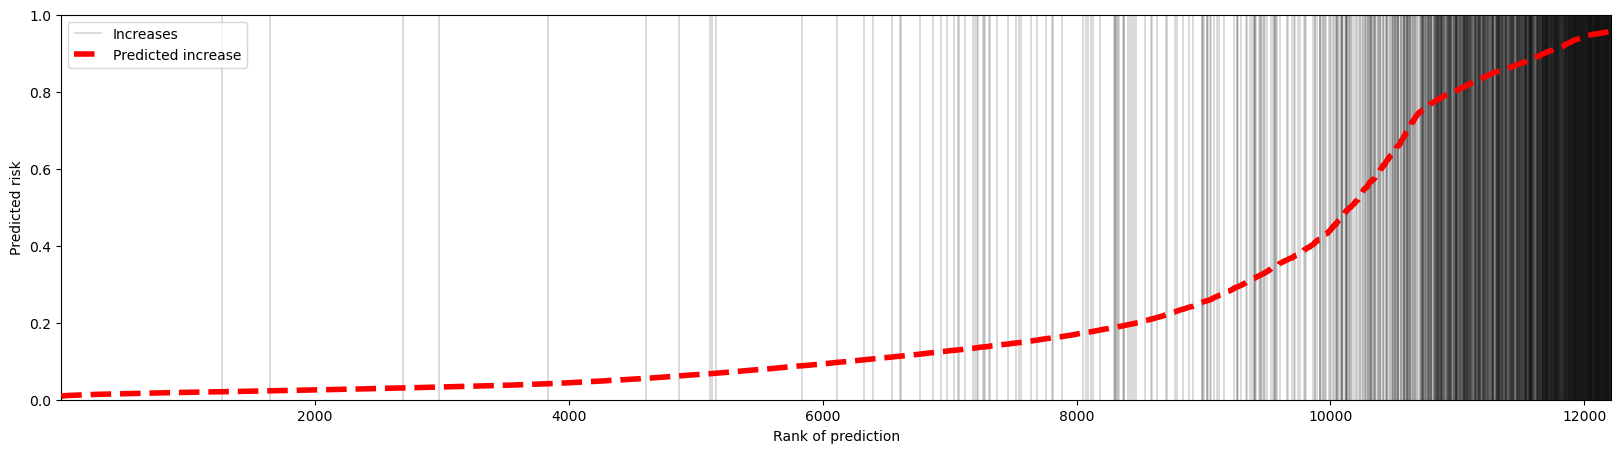

In [400]:
plot_targtes = ['armedconf']
plot_ffwds = [1]

algo = 'rf'
for target in plot_targtes:
    for forward in plot_ffwds:
        print('-----------------------------------------------------------------------------------------')
        print(f'STATISTICS FOR TAGRET {target}, predicting {forward} month(s) ahead')
        produce_stats(df, f'{target}_f{forward}', f'pred_{target}_{algo}_f{forward}')

## Root mean squared error (for regression)

In [401]:
fwds = [1,3,6]
models = ['all', 'hs', 'tx']

start_date = start_month_year #start_date ##start_date = dt.datetime(2018, 1, 2)

errors = {}

for algo in algos: 
    print('ALGORITHM:', algo)
    
    for model in models:

        for fwd in fwds:
                
                # get_tar_pred(df: pd.DataFrame() , fwd: int, model: str, start_time: dt, target: str, algo: str):
                y_trues, y_preds = get_tar_pred(df, fwd, model, start_date, target_regr, algo)
            
                errors[f'{model}_{fwd}'] = mean_squared_error(y_trues, y_preds)

    print('All Root Mean Squared Errors:')
    print(pd.Series(errors)) #.sort_values()

ALGORITHM: rf
All Root Mean Squared Errors:
all_1    0.623561
all_3    0.494066
all_6    0.374951
hs_1     0.620274
hs_3     0.490628
hs_6     0.372199
tx_1     0.957990
tx_3     0.717658
tx_6     0.590892
dtype: float64
ALGORITHM: xgb
All Root Mean Squared Errors:
all_1    0.631231
all_3    0.418932
all_6    0.339972
hs_1     0.587219
hs_3     0.405162
hs_6     0.352180
tx_1     0.860619
tx_3     0.623758
tx_6     0.511467
dtype: float64


## Plots by country for inspection

In [403]:
# before plotiing: move target value and prediction to one month ahead of the time of the prediction, i.e. add one months to the month_year column
# COMMENT OUT TO AVOID RUNNING MORE THAN ONCE
df['month_year'] = df['month_year'] + pd.DateOffset(months=1)
df.head(3)

isocode month_year  month  year Country Name  deaths_all_pc  armedconf  \
0     AFG 2018-02-01      1  2018  Afghanistan       4.838255       True   
1     AGO 2018-02-01      1  2018       Angola       0.000000      False   
2     ALB 2018-02-01      1  2018      Albania       0.000000      False   

   escalation  armedconf_since  share_events_1  ...  \
0           1                0       14.458252  ...   
1           0               24       12.282398  ...   
2           0              217       12.704471  ...   

   pred_deaths_all_pc_xgb_f3_tx  pred_armedconf_xgb_f6_all  \
0                      3.572988               9.999999e-01   
1                      0.153685               1.735305e-02   
2                      0.004114               5.838191e-08   

   pred_armedconf_xgb_f6_hs  pred_armedconf_xgb_f6_tx  \
0              9.998817e-01              1.000000e+00   
1              1.364875e-03              2.560665e-02   
2              6.490100e-07              1.530604e-08   

   pred_escalation_xgb_f6_all  pred_escalation_xgb_f6_hs  \
0                9.920353e-01                   0.995094   
1                6.402438e-04                   0.009946   
2                5.579168e-08                   0.000006   

   pred_escalation_xgb_f6_tx  pred_deaths_all_pc_xgb_f6_all  \
0               9.996713e-01                       2.151273   
1               4.744902e-03                       0.192119   
2               5.884992e-08                       0.183338   

   pred_deaths_all_pc_xgb_f6_hs  pred_deaths_all_pc_xgb_f6_tx  
0                      2.929380                      2.874567  
1                      0.187882                      0.188585  
2                      0.184252                      0.183291  

[3 rows x 123 columns]

In [476]:
# Check countries that would be hardest to predict for naive model

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# Counting the sequences of two consecutive values, grouped by 'isocode'
hadest_f1 = df.groupby(['isocode', 'Country Name']).apply(lambda x: pd.Series({
    'Armedc_00': sum((x['armedconf'].shift() == 0) & (x['armedconf'] == 0)),
    'Armedc_11': sum((x['armedconf'].shift() == 1) & (x['armedconf'] == 1)),
    'Armedc_01': sum((x['armedconf'].shift() == 0) & (x['armedconf'] == 1)),
    'Armedc_10': sum((x['armedconf'].shift() == 1) & (x['armedconf'] == 0)),

    'Escal_00': sum((x['escalation'].shift() == 0) & (x['escalation'] == 0)),
    'Escal_11': sum((x['escalation'].shift() == 1) & (x['escalation'] == 1)),
    'Escal_01': sum((x['escalation'].shift() == 0) & (x['escalation'] == 1)),
    'Escal_10': sum((x['escalation'].shift() == 1) & (x['escalation'] == 0)),
})).reset_index()

hadest_f1['Armedc_same'] = hadest_f1['Armedc_00'] + hadest_f1['Armedc_11']
hadest_f1['Armedc_diff'] = hadest_f1['Armedc_01'] + hadest_f1['Armedc_10']
hadest_f1['Escal_same'] = hadest_f1['Escal_00'] + hadest_f1['Escal_11']
hadest_f1['Escal_diff'] = hadest_f1['Escal_01'] + hadest_f1['Escal_10']

hadest_f1['Armedc_same_perc'] = round(hadest_f1['Armedc_same'] / (hadest_f1['Armedc_same'] + hadest_f1['Armedc_diff']) *100, 2)
hadest_f1['Escal_same_perc'] = round(hadest_f1['Escal_same'] / (hadest_f1['Escal_same'] + hadest_f1['Escal_diff']) *100, 2)

hadest_f1.sort_values('Armedc_diff', ascending=False, inplace=True)

hadest_f1[['isocode', 'Country Name', 'Armedc_same_perc', 'Escal_same_perc' ]].head(19) # 'Armedc_same', 'Armedc_diff', 'Escal_same', 'Escal_diff' 


isocode      Country Name  Armedc_same_perc  Escal_same_perc
10      BDI           Burundi             50.00            56.45
153     SDN             Sudan             51.61            58.06
170     TCD              Chad             54.84            51.61
87      ISR            Israel             62.90            56.45
23      BRA            Brazil             70.97            67.74
51      EGY  Egypt, Arab Rep.             70.97            80.65
129     NER             Niger             70.97            54.84
56      ETH          Ethiopia             72.58            58.06
37      COL          Colombia             74.19            77.42
141     PNG  Papua New Guinea             75.81            72.58
161     SSD       South Sudan             77.42            45.16
50      ECU           Ecuador             77.42            77.42
183     UKR           Ukraine             79.03            66.13
79      HTI             Haiti             80.65            74.19
93      KEN             Kenya             82.26            87.10
118     MMR           Myanmar             82.26            62.90
130     NGA           Nigeria             83.87            51.61
179     TUR           Turkiye             83.87            96.77
122     MOZ        Mozambique             83.87            51.61

In [479]:
aggregations = {
    'Armedc_same': 'sum',
    'Armedc_diff': 'sum',
    'Escal_same': 'sum',
    'Escal_diff': 'sum',
    'Armedc_same_perc': 'mean',
    'Escal_same_perc': 'mean'
}

# Perform the aggregation
aggregated_df = hadest_f1.agg(aggregations)

# Print the aggregated dataframe
print(aggregated_df)


Armedc_same         11737.000000
Armedc_diff           477.000000
Escal_same          11358.000000
Escal_diff            856.000000
Armedc_same_perc       96.094416
Escal_same_perc        92.991320
dtype: float64


In [483]:
# pick country, forecast horizon and model
country = 'NGA' #'COD'
#'SSD', BFA, LKA (srilanka), MMR (myanmar), IRQ (iraq), ETH (ethiopia), COD (congo), AFG (afghanistan), SOM (somalia), SYR (syria), UKR (ukraine), YEM (yemen), VEN (venezuela), ZWE (zimbabwe), VNM (vietnam), TUR (turkey), SDN (sudan), PAK (pakistan), NGA (nigeria), MEX (mexico), LBY (libya), IND (india), IDN (indonesia), EGY (egypt), COL (colombia), CAF (central african republic), BDI (burundi), BGD (bangladesh), BOL (bolivia), CMR (cameroon), CIV (cote d'ivoire), DZA (algeria), ECU (ecuador), GIN (guinea), HTI (haiti), KEN (kenya), LBN (lebanon), MDG (madagascar), MLI (mali), MOZ (mozambique), NER (niger), PHL (philippines), PRY (paraguay), RWA (rwanda), SLE (sierra leone), TCD (chad), TGO (togo), TUN (tunisia), UGA (uganda), ZMB (zambia), ZAF (south africa), TZA (tanzania), THA (thailand), SWE (sweden), NOR (norway), NLD (netherlands), MYS (malaysia), LUX (luxembourg), KOR (south korea), JPN (japan), ITA (italy), IRL (ireland), ISL (iceland), HUN (hungary), GRC (greece), GBR (united kingdom), FRA (france), FIN (finland), ESP (spain), DNK (denmark), DEU (germany), CZE (czech republic), CAN (canada), BEL (belgium), AUT (austria), AUS (australia), ARG (argentina), USA (united states), CHE (switzerland), CHL (chile), BRA (brazil), POL (poland), PRT (portugal), NZL (new zealand), MEX (
forward = 1

# get country df
country_name = pc.countries.get(alpha_3=country)
country_clsf =  df[df.isocode == country]

In [484]:
df.loc[df[unit_of_analyis]==country, [unit_of_analyis] + text_gdelt_vars]

country_clsf[['month_year' , 'month', 'armedconf','armedconf_f1', 'armedconf_f3', 'pred_armedconf_rf_f1_tx']].head(10)

month_year  month  armedconf  armedconf_f1  armedconf_f3  \
130  2018-02-01      1       True           1.0           1.0   
327  2018-03-01      2       True           1.0           1.0   
524  2018-04-01      3       True           1.0           1.0   
721  2018-05-01      4       True           1.0           1.0   
918  2018-06-01      5       True           1.0           1.0   
1115 2018-07-01      6       True           1.0           1.0   
1312 2018-08-01      7       True           1.0           1.0   
1509 2018-09-01      8       True           1.0           1.0   
1706 2018-10-01      9       True           1.0           1.0   
1903 2018-11-01     10       True           1.0           1.0   

      pred_armedconf_rf_f1_tx  
130                  0.860407  
327                  0.855961  
524                  0.825082  
721                  0.873704  
918                  0.862048  
1115                 0.851823  
1312                 0.853581  
1509                 0.776214  
1706                 0.798513  
1903                 0.839715

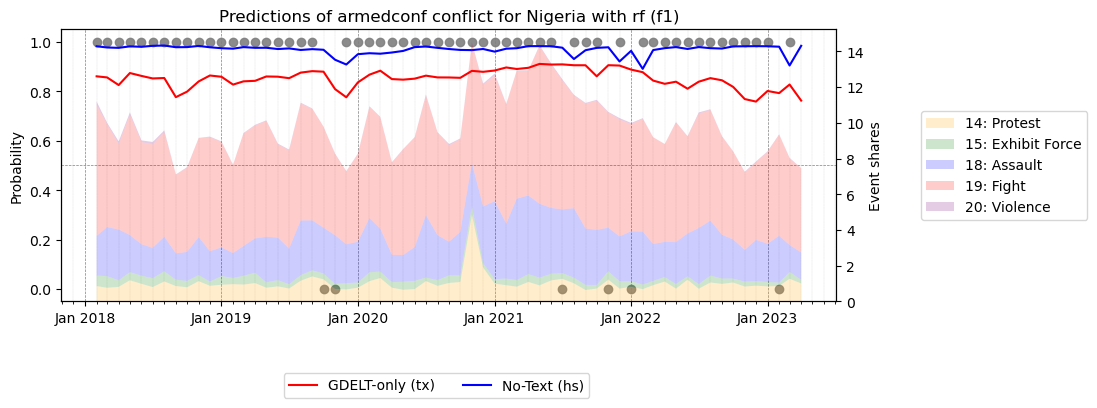

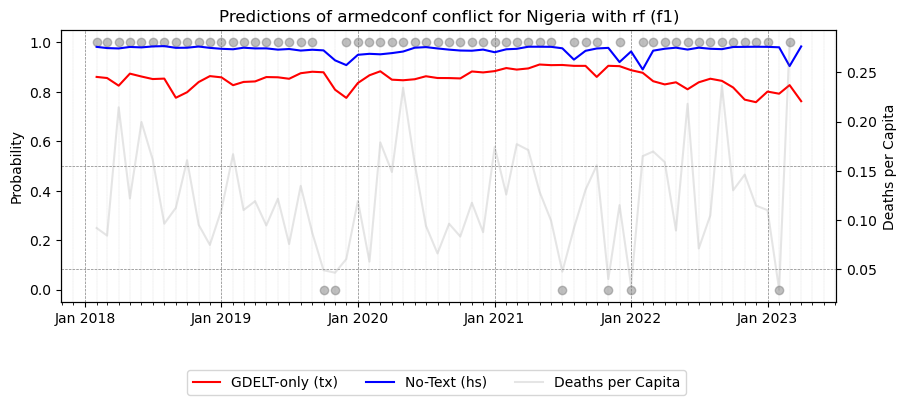

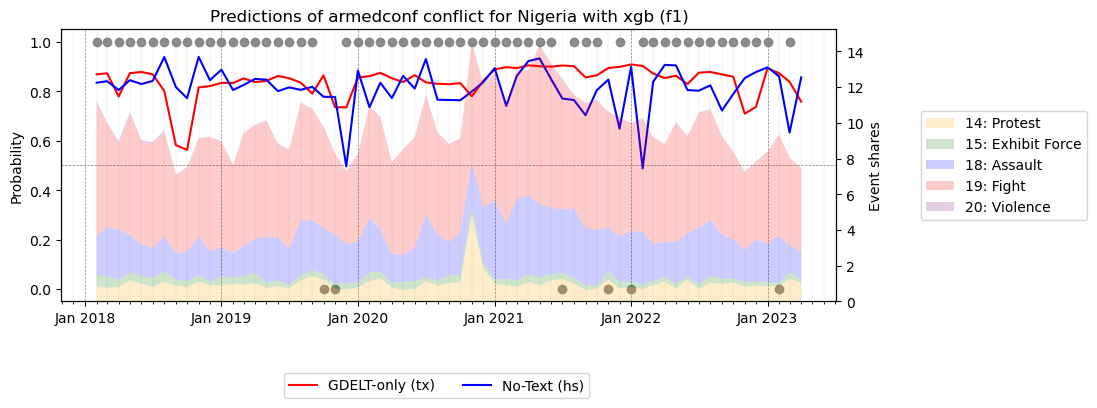

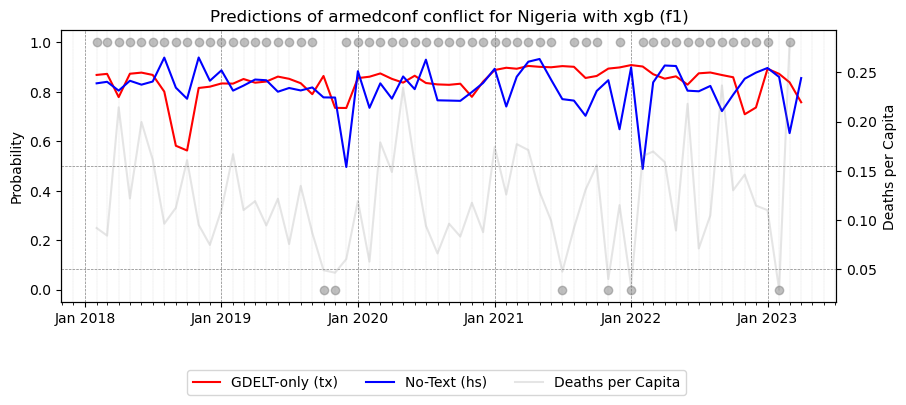

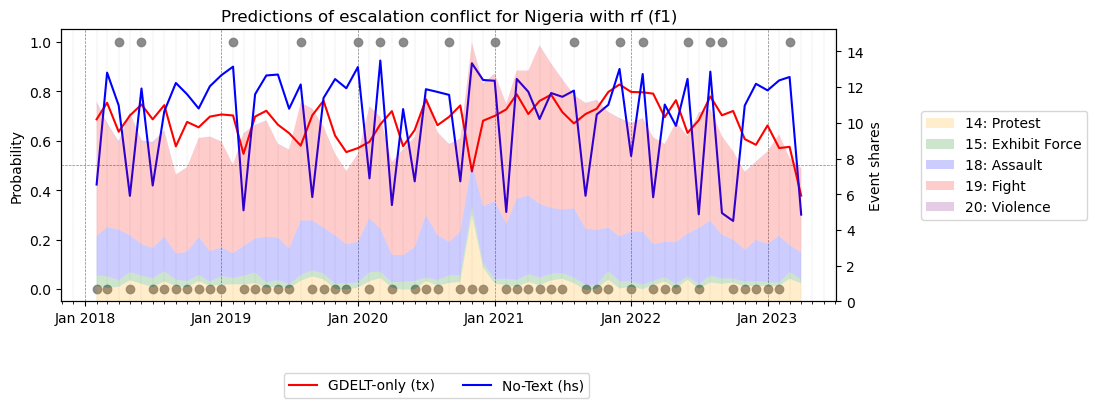

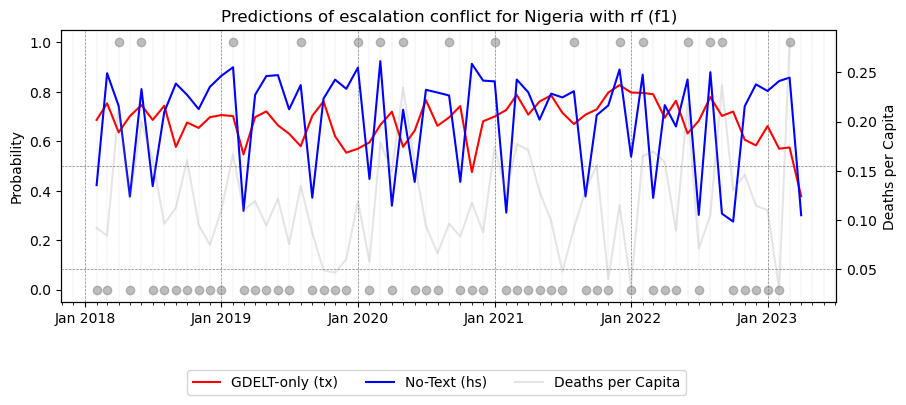

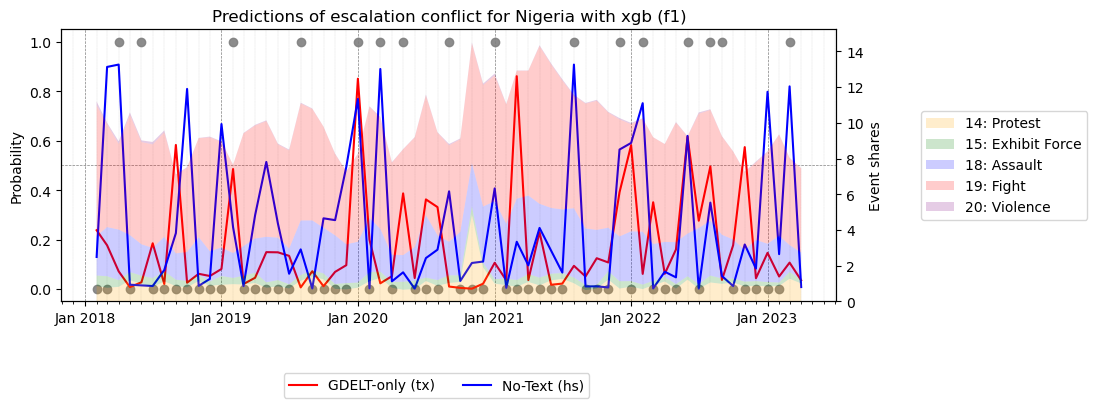

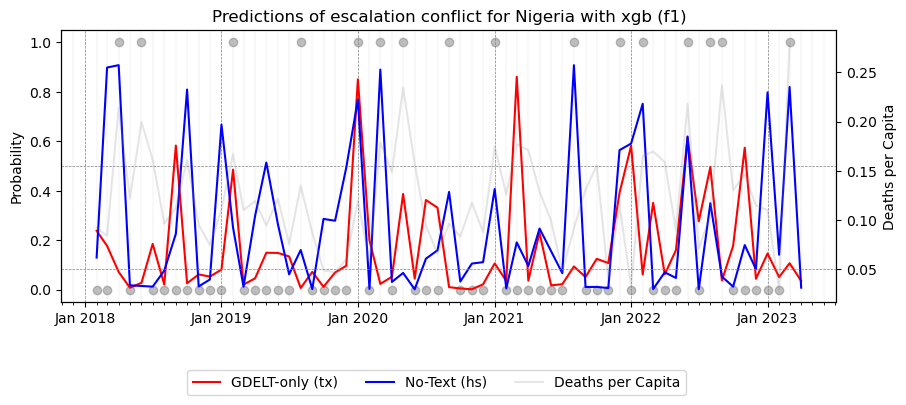

In [485]:
# Define the colors for the stacked line chart
colors = ['orange', 'green', 'blue', 'red', 'purple']
#colors = ['magenta', 'pink', 'teal', 'yellow', 'cyan']
#colors = ['magenta', 'purple', 'pink', 'cyan', 'yellow']

for target in clsf_targets:
    for algo in algos:
        fig, ax1 = plt.subplots(figsize=(10, 4)) 

        plt.axhline(y = 0.5, color = 'grey', linestyle = '--', linewidth = 0.5)


        # Plot the primary y-axis for 'probability'
        ax1.plot(country_clsf.month_year, country_clsf[f'pred_{target}_{algo}_f{forward}_tx'], label='GDELT-only (tx)', color='red')
        ax1.plot(country_clsf.month_year, country_clsf[f'pred_{target}_{algo}_f{forward}_hs'], label='No-Text (hs)', color='blue')

        ax1.scatter(country_clsf.month_year, country_clsf[f'{target}_f{forward}'], linewidth=1, label='Actual', alpha=0.9, color='grey')

        ax1.set_ylabel('Probability')

        # Create a secondary y-axis for 'deaths per capita'
        ax2 = ax1.twinx()
        #ax2.plot(country_clsf.month_year, country_clsf['deaths_all_pc'], label='Deaths per Capita', alpha = 0.6, color='grey')
        #ax2.set_ylabel('Deaths per Capita')

        ax2.stackplot(country_clsf.month_year, 
              country_clsf['share_events_14'], country_clsf['share_events_15'], country_clsf['share_events_18'], 
              country_clsf['share_events_19'], country_clsf['share_events_20'],
              labels=['14: Protest', '15: Exhibit Force', '18: Assault', '19: Fight', '20: Violence'], colors=colors, alpha=0.2)
        ax2.set_ylabel('Event shares')
        #ax2.legend(loc='upper left')
        ax2.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))


        plt.title(f'Predictions of {target} conflict for {country_name.name} with {algo} (f{forward})')

        # Set the x-axis ticker formatter to display months
        ax1.xaxis.set_major_locator(mdates.YearLocator())
        ax1.xaxis.set_minor_locator(mdates.MonthLocator())

        # Add vertical gridlines for each month
        ax1.xaxis.grid(True, which='minor', color='grey', linestyle='--', linewidth=0.1)

        # Set thicker line width for major ticks
        ax1.xaxis.grid(True, which='major', color='grey', linestyle='--', linewidth=0.5)

        # Format the x-axis tick labels as '%b %Y' (e.g., Jan 2022)
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

        #ax1.set_xticks(rotation=45)
        plt.xticks(rotation=45)

        #Create a combined legend outside of the figure
        lines = ax1.get_lines() + ax2.get_lines()
        labels = [line.get_label() for line in lines]
        fig.legend(lines, labels, loc='center', bbox_to_anchor=(0.5, -0.01), ncol=4)
        
        # lines1 = ax1.get_lines()
        # lines2 = ax2.get_lines()
        # labels1 = [line.get_label() for line in lines1]
        # labels2 = [line.get_label() for line in lines2]
        # all_lines = lines1 + lines2
        # all_labels = labels1 + labels2
        #fig.legend(all_lines, all_labels, loc='center', bbox_to_anchor=(0.5, -0.01), ncol=4)
        #fig.legend(lines, labels, loc='center', bbox_to_anchor=(0.5, -0.001), ncol=4)

        plt.subplots_adjust(bottom=0.2)
        plt.show()

        fig, ax1 = plt.subplots(figsize=(10, 4)) 

        plt.axhline(y = 0.5, color = 'grey', linestyle = '--', linewidth = 0.5)

        # Plot the primary y-axis for 'probability'
        ax1.plot(country_clsf.month_year, country_clsf[f'pred_{target}_{algo}_f{forward}_tx'], label='GDELT-only (tx)', color='red')
        ax1.plot(country_clsf.month_year, country_clsf[f'pred_{target}_{algo}_f{forward}_hs'], label='No-Text (hs)', color='blue')

        ax1.scatter(country_clsf.month_year, country_clsf[f'{target}_f{forward}'], linewidth=1, label='Actual', alpha=0.5, color='grey')

        ax1.set_ylabel('Probability')

        # Create a secondary y-axis for 'deaths per capita'
        ax2 = ax1.twinx()
        ax2.plot(country_clsf.month_year, country_clsf['deaths_all_pc_f1'], label='Deaths per Capita', alpha = 0.2, color='grey')
        ax2.set_ylabel('Deaths per Capita')
        ax2.axhline(y = 0.05, color = 'grey', linestyle = '--', linewidth = 0.5)

        plt.title(f'Predictions of {target} conflict for {country_name.name} with {algo} (f{forward})')

        # Set the x-axis ticker formatter to display months
        ax1.xaxis.set_major_locator(mdates.YearLocator())
        ax1.xaxis.set_minor_locator(mdates.MonthLocator())

        # Add vertical gridlines for each month
        ax1.xaxis.grid(True, which='minor', color='grey', linestyle='--', linewidth=0.1)

        # Set thicker line width for major ticks
        ax1.xaxis.grid(True, which='major', color='grey', linestyle='--', linewidth=0.5)

        # Format the x-axis tick labels as '%b %Y' (e.g., Jan 2022)
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

        plt.xticks(rotation=45)

        # Create a combined legend outside of the figure
        lines = ax1.get_lines() + ax2.get_lines()
        labels = [line.get_label() for line in lines]
        fig.legend(lines, labels, loc='center', bbox_to_anchor=(0.5, -0.001), ncol=4)

        plt.subplots_adjust(bottom=0.2)

        plt.show()

In [473]:
# # plots for classification targets
# for target in clsf_targets:
#     for algo in algos:
#         fig = plt.figure(figsize=(10,4)) 

#         for model in ['tx', 'hs']: #'all',
#             plt.plot(country_clsf.month_year,country_clsf[f'pred_{target}_{algo}_f{forward}_{model}'], label = f'Predicted ({model})')

#         plt.scatter(country_clsf.month_year,country_clsf[f'{target}_f{forward}'], linewidth=1, label = 'Actual', alpha=0.5)
        
#         plt.title(f'Predictions of {target} conflict for {country_name.name} with {algo} (f{forward})')
#         plt.legend()
        
#         plt.grid(color='grey', linestyle='--', linewidth=0.1)
#         plt.xticks(rotation=45)
#         plt.show()


############################################################################################################


# # Convert the 'month_year' column to datetime format
# #country_clsf['month_year'] = pd.to_datetime(country_clsf['month_year'])


# for target in clsf_targets:
#     for algo in algos:
#         fig = plt.figure(figsize=(10, 4)) 

#         plt.plot(country_clsf.month_year, country_clsf[f'pred_{target}_{algo}_f{forward}_tx'], label='Predicted (tx)', color='orange')
#         plt.plot(country_clsf.month_year, country_clsf[f'pred_{target}_{algo}_f{forward}_hs'], label='Predicted (hs)', color='green')

#         plt.scatter(country_clsf.month_year, country_clsf[f'{target}_f{forward}'], linewidth=1, label='Actual', alpha=0.5)

#         plt.title(f'Predictions of {target} conflict for {country_name.name} with {algo} (f{forward})')
#         plt.legend()

#         # Set the x-axis ticker formatter to display months
#         ax = plt.gca()
#         ax.xaxis.set_major_locator(mdates.YearLocator())
#         ax.xaxis.set_minor_locator(mdates.MonthLocator())

#         # Add vertical gridlines for each month
#         ax.xaxis.grid(True, which='minor', color='grey', linestyle='--', linewidth=0.5)

#         # Set thicker line width for major ticks
#         ax.xaxis.grid(True, which='major', color='grey', linestyle='--', linewidth=1)

#         # Format the x-axis tick labels as '%b %Y' (e.g., Jan 2022)
#         ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

#         plt.xticks(rotation=45)
#         plt.show()


############################################################################################################
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates

# # Convert the 'month_year' column to datetime format
# #country_clsf['month_year'] = pd.to_datetime(country_clsf['month_year'])

# # Define the colors for the stacked line chart
# colors = ['orange', 'green', 'blue', 'red', 'purple']

# # Plotting the stacked line chart
# plt.figure(figsize=(10, 6))  # Adjust the figure size as per your requirement
# plt.stackplot(country_clsf.month_year, 
#               country_clsf['share_events_14'], country_clsf['share_events_15'], country_clsf['share_events_18'], 
#               country_clsf['share_events_19'], country_clsf['share_events_20'],
#               labels=['14: Protest', '15: Show Force', '18:', '19: Fight', '20: Violence'], colors=colors)

# plt.scatter(country_clsf.month_year, country_clsf[f'{target}_f{forward}'], linewidth=1, label='Actual', alpha=1, color='black')
# plt.title('Event Shares over Time')
# plt.xlabel('Month/Year')
# plt.ylabel('Event Shares')
# #plt.legend(loc='upper left')
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# plt.xticks(rotation=45)  # Rotating x-axis labels if needed

# # Set the x-axis ticker formatter to display months
# plt.gca().xaxis.set_major_locator(mdates.YearLocator())
# plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())

# # Add vertical gridlines for each month
# plt.gca().xaxis.grid(True, which='minor', color='grey', linestyle='--', linewidth=0.1)

# # Set thicker line width for major ticks
# plt.gca().xaxis.grid(True, which='major', color='grey', linestyle='--', linewidth=0.5)

# # Format the x-axis tick labels as '%b %Y' (e.g., Jan 2022)
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# plt.grid(True)
# plt.show()


############################################################################################################
# works but combined with above

#for target in clsf_targets:
#     for algo in algos:
#         fig, ax1 = plt.subplots(figsize=(10, 4)) 

#         plt.axhline(y = 0.5, color = 'grey', linestyle = '--', linewidth = 0.5)

#         # Plot the primary y-axis for 'probability'
#         ax1.plot(country_clsf.month_year, country_clsf[f'pred_{target}_{algo}_f{forward}_tx'], label='GDELT-only (tx)', color='orange')
#         ax1.plot(country_clsf.month_year, country_clsf[f'pred_{target}_{algo}_f{forward}_hs'], label='No-Text (hs)', color='green')

#         ax1.scatter(country_clsf.month_year, country_clsf[f'{target}_f{forward}'], linewidth=1, label='Actual', alpha=0.5, color='grey')

#         ax1.set_ylabel('Probability')

#         # Create a secondary y-axis for 'deaths per capita'
#         ax2 = ax1.twinx()
#         ax2.plot(country_clsf.month_year, country_clsf['deaths_all_pc_f1'], label='Deaths per Capita', alpha = 0.2, color='grey')
#         ax2.set_ylabel('Deaths per Capita')
#         ax2.axhline(y = 0.05, color = 'grey', linestyle = '--', linewidth = 0.5)

#         plt.title(f'Predictions of {target} conflict for {country_name.name} with {algo} (f{forward})')

#         # Set the x-axis ticker formatter to display months
#         ax1.xaxis.set_major_locator(mdates.YearLocator())
#         ax1.xaxis.set_minor_locator(mdates.MonthLocator())

#         # Add vertical gridlines for each month
#         ax1.xaxis.grid(True, which='minor', color='grey', linestyle='--', linewidth=0.1)

#         # Set thicker line width for major ticks
#         ax1.xaxis.grid(True, which='major', color='grey', linestyle='--', linewidth=0.5)

#         # Format the x-axis tick labels as '%b %Y' (e.g., Jan 2022)
#         ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

#         plt.xticks(rotation=45)

#         # Create a combined legend outside of the figure
#         lines = ax1.get_lines() + ax2.get_lines()
#         labels = [line.get_label() for line in lines]
#         fig.legend(lines, labels, loc='center', bbox_to_anchor=(0.5, -0.001), ncol=4)

#         plt.subplots_adjust(bottom=0.2)

#         plt.show()



############################################################################################################

# # Define the colors for the stacked line chart
# colors = ['orange', 'green', 'blue', 'red', 'purple']
# #colors = ['magenta', 'pink', 'teal', 'yellow', 'cyan']
# #colors = ['magenta', 'purple', 'pink', 'cyan', 'yellow']


# for target in clsf_targets:
#     for algo in algos:
#         fig, ax1 = plt.subplots(figsize=(10, 4)) 

#         plt.axhline(y = 0.5, color = 'grey', linestyle = '--', linewidth = 0.5)


#         # Plot the primary y-axis for 'probability'
#         ax1.plot(country_clsf.month_year, country_clsf[f'pred_{target}_{algo}_f{forward}_tx'], label='GDELT-only (tx)', color='red')
#         ax1.plot(country_clsf.month_year, country_clsf[f'pred_{target}_{algo}_f{forward}_hs'], label='No-Text (hs)', color='blue')

#         ax1.scatter(country_clsf.month_year, country_clsf[f'{target}_f{forward}'], linewidth=1, label='Actual', alpha=0.9, color='grey')

#         ax1.set_ylabel('Probability')

#         # Create a secondary y-axis for 'deaths per capita'
#         ax2 = ax1.twinx()
#         #ax2.plot(country_clsf.month_year, country_clsf['deaths_all_pc'], label='Deaths per Capita', alpha = 0.6, color='grey')
#         #ax2.set_ylabel('Deaths per Capita')

#         ax2.stackplot(country_clsf.month_year, 
#               country_clsf['share_events_14'], country_clsf['share_events_15'], country_clsf['share_events_18'], 
#               country_clsf['share_events_19'], country_clsf['share_events_20'],
#               labels=['14: Protest', '15: Exhibit Force', '18: Assault', '19: Fight', '20: Violence'], colors=colors, alpha=0.2)
#         ax2.set_ylabel('Event shares')
#         #ax2.legend(loc='upper left')
#         ax2.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))


#         plt.title(f'Predictions of {target} conflict for {country_name.name} with {algo} (f{forward})')

#         # Set the x-axis ticker formatter to display months
#         ax1.xaxis.set_major_locator(mdates.YearLocator())
#         ax1.xaxis.set_minor_locator(mdates.MonthLocator())

#         # Add vertical gridlines for each month
#         ax1.xaxis.grid(True, which='minor', color='grey', linestyle='--', linewidth=0.1)

#         # Set thicker line width for major ticks
#         ax1.xaxis.grid(True, which='major', color='grey', linestyle='--', linewidth=0.5)

#         # Format the x-axis tick labels as '%b %Y' (e.g., Jan 2022)
#         ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

#         #ax1.set_xticks(rotation=45)
#         plt.xticks(rotation=45)

#         #Create a combined legend outside of the figure
#         lines = ax1.get_lines() + ax2.get_lines()
#         labels = [line.get_label() for line in lines]
#         fig.legend(lines, labels, loc='center', bbox_to_anchor=(0.5, -0.01), ncol=4)
        
#         # lines1 = ax1.get_lines()
#         # lines2 = ax2.get_lines()
#         # labels1 = [line.get_label() for line in lines1]
#         # labels2 = [line.get_label() for line in lines2]
#         # all_lines = lines1 + lines2
#         # all_labels = labels1 + labels2
#         #fig.legend(all_lines, all_labels, loc='center', bbox_to_anchor=(0.5, -0.01), ncol=4)
#         #fig.legend(lines, labels, loc='center', bbox_to_anchor=(0.5, -0.001), ncol=4)

#         plt.subplots_adjust(bottom=0.2)
#         plt.show()

In [454]:
%history

import pandas as pd
import os
from datetime import datetime as dt

from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score, precision_recall_curve, auc
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

import pycountry as pc

import warnings
warnings.filterwarnings('ignore')
# classification targets
target_conf = 'armedconf'
target_escl = 'escalation'

# regression target
target_regr = 'deaths_all_pc'

# many features are made per-country
unit_of_analyis = 'isocode'

# start and end of test set
start_month_year = dt(2018, 1, 1)
end_month_year = dt(2023, 3, 1)

# time horizons forecase for
fwds = [1,3,6]

# target groupings
clsf_targets = [target_conf, target_escl]
regr_targets = [target_regr]

all_targets = clsf_targets + regr_targets

# algorithms used
algos = ['rf', 'xgb']
path = os.getcwd()
parent_path = os.path.abspath(os.path.join(path, os.pa

In [453]:
%history


import pandas as pd
import os
from datetime import datetime as dt

from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score, precision_recall_curve, auc
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

import pycountry as pc

import warnings
warnings.filterwarnings('ignore')
# classification targets
target_conf = 'armedconf'
target_escl = 'escalation'

# regression target
target_regr = 'deaths_all_pc'

# many features are made per-country
unit_of_analyis = 'isocode'

# start and end of test set
start_month_year = dt(2018, 1, 1)
end_month_year = dt(2023, 3, 1)

# time horizons forecase for
fwds = [1,3,6]

# target groupings
clsf_targets = [target_conf, target_escl]
regr_targets = [target_regr]

all_targets = clsf_targets + regr_targets

# algorithms used
algos = ['rf', 'xgb']
path = os.getcwd()
parent_path = os.path.abspath(os.path.join(path, os.pa

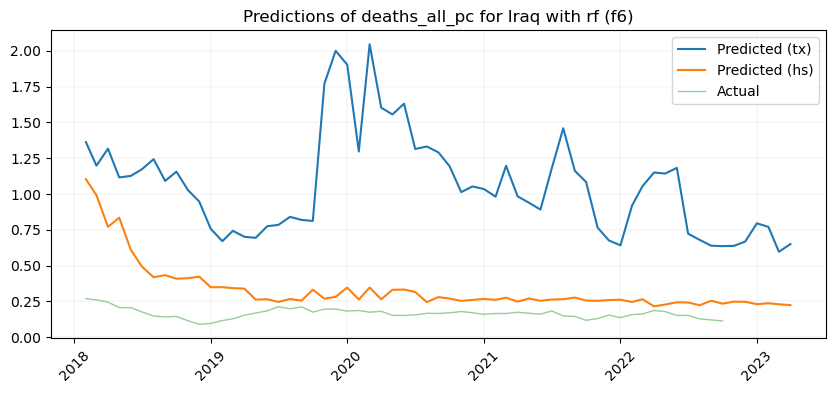

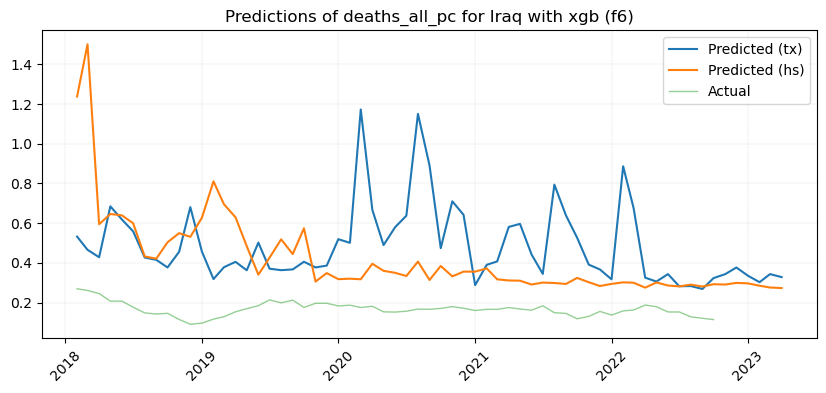

In [409]:
# plots for regression targets

for algo in algos:
    plt.figure(figsize=(10,4))


    for model in ['tx', 'hs']: #'all', 
        plt.plot(country_clsf.month_year,country_clsf[f'pred_{target_regr}_{algo}_f{forward}_{model}'], label = f'Predicted ({model})')

    plt.plot(country_clsf.month_year,country_clsf[f'{target_regr}_f{forward}'], linewidth=1, label = 'Actual', alpha=0.5)

    plt.title(f'Predictions of {target_regr} for {country_name.name} with {algo} (f{forward})')
    plt.legend()
    plt.grid(color='grey', linestyle='--', linewidth=0.1)
    plt.xticks(rotation=45)
    plt.show()

## Metrics for Naive Baseline Model
This model simply predicts that the future month(s) will be like the current month.

### Data prep
The difficulty was that in order to compare like with like, we needed to ensure that for the evaluation of the f3 and f6 models, the final 3 and 6 rows are dropped. In the original code, the make_target function generate NaN values, for which the rows are dropped. Here we need to 'artificially' drop the correct number of rows. In order to match the logic of our existing functions we also generate the different 'f1' etc names (and put an 'n' for the algorithm) even though the values are always the same.

In [482]:
# create naive predctions 1 month ahead
df_nv1 = df.copy()
shifts = [1]
for i in shifts:
    df_nv1[f'pred_{target_conf}_n_f{i}_nv'] = df_nv1.groupby(unit_of_analyis)[target_conf].shift(i)
    df_nv1[f'pred_{target_escl}_n_f{i}_nv'] = df_nv1.groupby(unit_of_analyis)[target_escl].shift(i)
    df_nv1[f'pred_{target_regr}_n_f{i}_nv'] = df_nv1.groupby(unit_of_analyis)[target_regr].shift(i) 
    # drop the final month for each country (the attempt to fill them with NaN did not work)
    df_nv1 = df_nv1.groupby(unit_of_analyis).apply(lambda x: x.iloc[:-(i)])
     #df_nv1[f'pred_{target_regr}__f{i}_nv'] = df_nv1.groupby(unit_of_analyis)[f'pred_{target_regr}__f{i}_nv'].transform(lambda x: x if x.name != x.index[-i] else np.nan)
df_nv1.reset_index(drop=True, inplace=True)
print(len(df_nv1))


# create naive predctions 3 months ahead (using the 1 month ahead predictions)
df_nv2 = df_nv1.copy()
shifts = [3]
for i in shifts:
    df_nv2[f'pred_{target_conf}_n_f{i}_nv'] = df_nv2[f'pred_{target_conf}_n_f1_nv']
    df_nv2[f'pred_{target_escl}_n_f{i}_nv'] = df_nv2[f'pred_{target_escl}_n_f1_nv']
    df_nv2[f'pred_{target_regr}_n_f{i}_nv'] = df_nv2[f'pred_{target_regr}_n_f1_nv']   
    df_nv2 = df_nv2.groupby(unit_of_analyis).apply(lambda x: x.iloc[:-(i-1)]) # don't drop three rows as one already dropped above
df_nv2.reset_index(drop=True, inplace=True)
print(len(df_nv2))

# create naive predctions 6 months ahead (using the 1 month ahead predictions)
df_nv_all = df_nv2.copy()
shifts = [6]
for i in shifts:
    df_nv_all[f'pred_{target_conf}_n_f{i}_nv'] = df_nv_all[f'pred_{target_conf}_n_f1_nv']
    df_nv_all[f'pred_{target_escl}_n_f{i}_nv'] = df_nv_all[f'pred_{target_escl}_n_f1_nv']
    df_nv_all[f'pred_{target_regr}_n_f{i}_nv'] = df_nv_all[f'pred_{target_regr}_n_f1_nv']
    df_nv_all = df_nv_all.groupby(unit_of_analyis).apply(lambda x: x.iloc[:-(i-3)]) # don't drop six rows as three already dropped above
df_nv_all.reset_index(drop=True, inplace=True)
print(len(df_nv_all))

12214
11820
11229


In [411]:
# check if right columns were dropped

#df_nv1.loc[df_nv1['isocode'] == 'AFG', ['isocode', 'month_year','pred_armedconf_n_f1_nv']][-4:]
df_nv2.loc[df_nv2['isocode'] == 'AFG', ['isocode', 'month_year','pred_armedconf_n_f3_nv']][-4:]
#df_nv_all.loc[df_nv_all['isocode'] == 'AFG', ['isocode', 'month_year','pred_armedconf__f6_nv']]#[-4:]

isocode month_year pred_armedconf_n_f3_nv
56     AFG 2022-10-01                   True
57     AFG 2022-11-01                   True
58     AFG 2022-12-01                   True
59     AFG 2023-01-01                   True

### ROC and precision re-call curves (for classification baseline)

Model: nv
ROC: 0.884 Precision: 0.651

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     10780
         1.0       0.79      0.79      0.79      1237

    accuracy                           0.96     12017
   macro avg       0.89      0.88      0.88     12017
weighted avg       0.96      0.96      0.96     12017



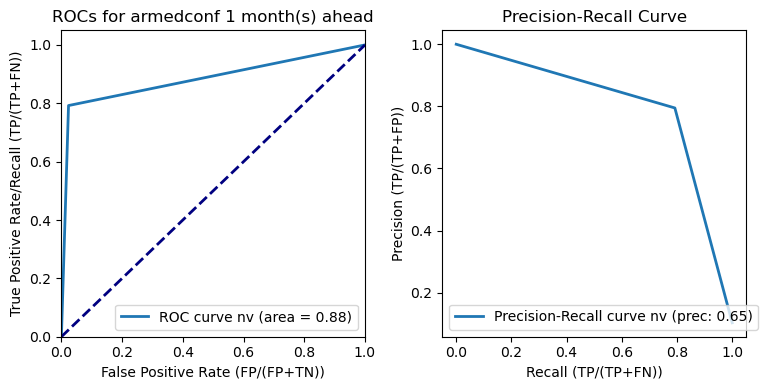

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
Model: nv
ROC: 0.837 Precision: 0.657

Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     10051
         1.0       0.90      0.69      0.78      1572

    accuracy                           0.95     11623
   macro avg       0.92      0.84      0.87     11623
weighted avg       0.94      0.95      0.94     11623



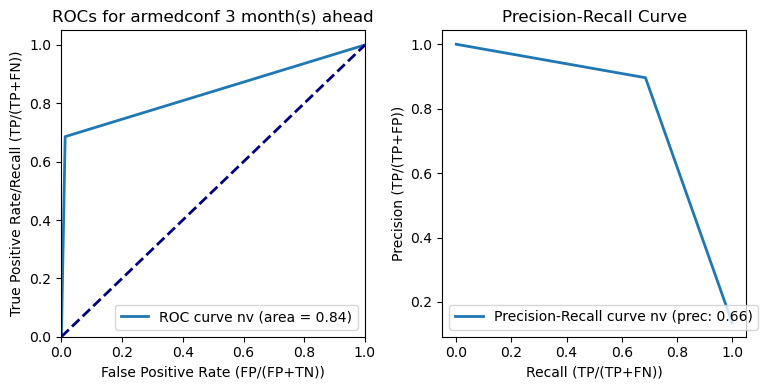

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
Model: nv
ROC: 0.792 Precision: 0.619

Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      9258
         1.0       0.93      0.59      0.72      1774

    accuracy                           0.93     11032
   macro avg       0.93      0.79      0.84     11032
weighted avg       0.93      0.93      0.92     11032



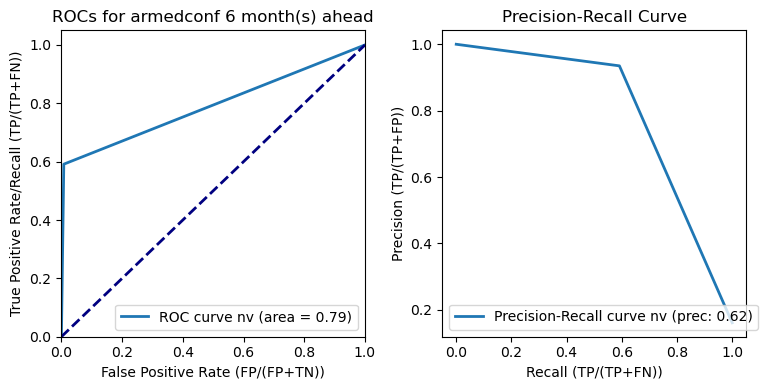

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
Model: nv
ROC: 0.604 Precision: 0.087

Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.97      0.97     11547
         1.0       0.24      0.24      0.24       470

    accuracy                           0.94     12017
   macro avg       0.61      0.60      0.60     12017
weighted avg       0.94      0.94      0.94     12017



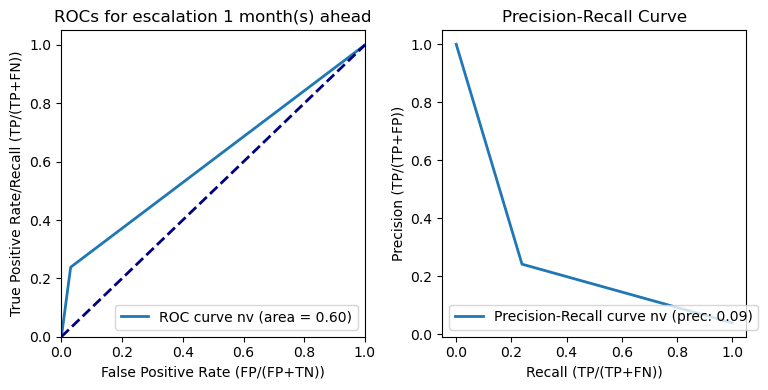

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
Model: nv
ROC: 0.605 Precision: 0.209

Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.98      0.95     10464
         1.0       0.58      0.23      0.33      1159

    accuracy                           0.91     11623
   macro avg       0.75      0.60      0.64     11623
weighted avg       0.89      0.91      0.89     11623



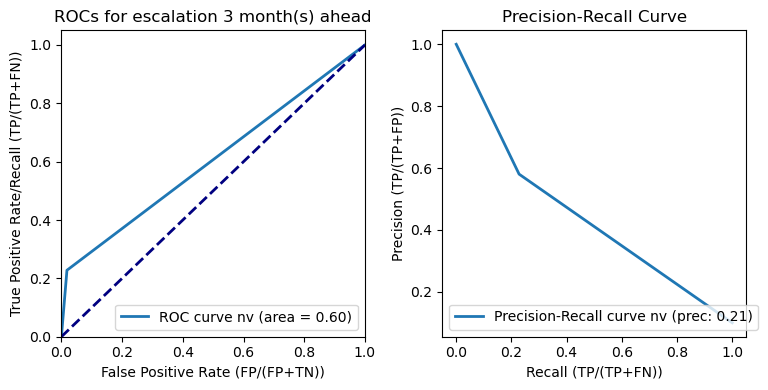

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
Model: nv
ROC: 0.602 Precision: 0.285

Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.99      0.93      9419
         1.0       0.80      0.21      0.34      1613

    accuracy                           0.88     11032
   macro avg       0.84      0.60      0.63     11032
weighted avg       0.87      0.88      0.85     11032



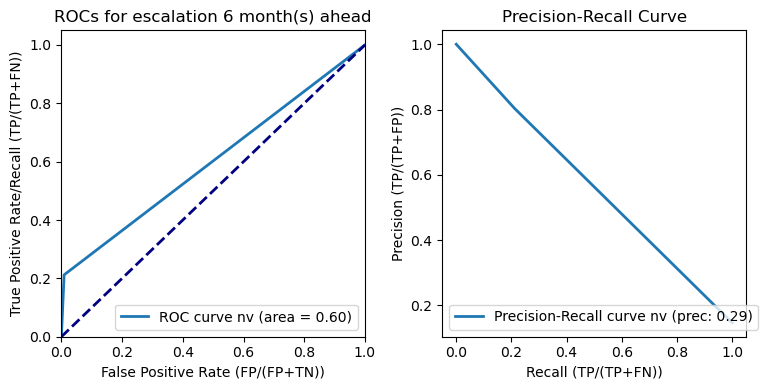

- - - - -- - - - - - - - - - - - - - - - - - - - - - 


In [412]:
#get_tar_pred(df_nv, 1, model: 'nv', start_time: dt, target: str, type: str):

#get_roc_pr(df_og = df_nv, fwd = 1, target: str, models: list, staryearid, binary=True, plot=True):

fwds = [1,3,6]

for target in ['armedconf', 'escalation']:
    for sft in fwds:
        #print(target, f'f_{sft}') #, model)
        # et_roc_pr(df, sft, target, ['all', 'tx', 'hs'], start_month_year, algo = algo)
        if sft == 1:
            get_roc_pr(df_nv1, sft, target, ['nv'], start_month_year, algo= 'n')
            
        elif sft == 3:
            get_roc_pr(df_nv2, sft, target, ['nv'], start_month_year, algo= 'n')
        elif sft == 6:
            get_roc_pr(df_nv_all, sft, target, ['nv'], start_month_year, algo= 'n')

        print('- - - - -- - - - - - - - - - - - - - - - - - - - - - ')

### Root mean squared error (for regression baseline)

In [413]:
errors = {}
for fwd in fwds:
#    for model in models:
            
            y_trues, y_preds = get_tar_pred(df_nv_all, fwd, 'nv', start_month_year, target_regr, 'n')
        
            errors[f'nv_{fwd}'] = mean_squared_error(y_trues, y_preds)

print('All Root Mean Squared Errors:')
print(pd.Series(errors)) #.sort_values()

All Root Mean Squared Errors:
nv_1    1.169084
nv_3    0.935629
nv_6    0.838287
dtype: float64
